<a href="https://colab.research.google.com/github/echoheqian/drug-target-master/blob/main/0514_dbgap_sleep_cvds_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A complete ML Pipeline Tutorial 

## 1. import packages needed for ML

In [2]:
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

sys.setrecursionlimit(1000000)

## set a seed for code reproducibility 

In [3]:
SEED = 7
np.random.seed(SEED)
pd.set_option('display.max_columns', 180)

## 2. Data preparing

### 2.1 Loading data

In [ ]:
df = (pd.read_csv('pheno.prs.0421.csv', sep="\t"))
# getting dataframe columns names
df_name = df.columns
print(df.head())
print(df.shape)
print(df_name)

In [5]:
## 2023-04-09 try my own dataset
#cols = ['age','dm_trial','smk_now','alc_now','coffee',
#        'sbp','dbp','bmi','glu','chol','ldl','hdl','tg','insu','baseline_hsCRP',
#        'tot_cal','baseline_fat','baseline_pro','baseline_cho','baseline_alc',
#        'baseline_fiber','baseline_fruit','baseline_veg','baseline_palm',
#        'baseline_linoleic','baseline_n3','baseline_n6','baseline_sodium',
#        'baseline_nuts','baseline_grains','baseline_suger',
#        'baseline_dairy','baseline_fish','hei',
#        'baseline_sleepdis','baseline_mse','baseline_ces_d','baseline_sleep_hour',
#        'delta_sleep','delta_ces_d',
#        'low_cal_diet','low_fat_diet','low_salt_diet','high_fiber_diet','diabetic_diet','lactose_free_diet',
#        'time_walk_10min','time_hard_ex','time_moderate_ex','time_mild_ex'
#        'high_chol_his','cvd_his','hypertension_his','cancer_his',
#        'SCORE_baseline_sleep_p0.05_0.05','SCORE_inso_all_group',
#        'mi','chd','isch_stroke','hemo_stroke','dm']
df = (pd.read_csv('pheno.prs.0421.csv', sep="\t")
        .query('dm_trial==True')
        .drop('dm_trial', axis=1))
df.shape

(5832, 338)

In [6]:
def get_cvd_type(x):
  if x['mi'] == 1 or x['chd'] ==1 or x['dm'] ==1 or x['isch_stroke']==1 or x['hemo_stroke']==1:
    return 1
  else: 
    return 0
df.loc[:, 'cvd_binary'] = df.apply(get_cvd_type, axis=1)
print(df['cvd_binary'].value_counts())

0    4473
1    1359
Name: cvd_binary, dtype: int64


### 2.1.1 将之前替换为-9的missing value替换回来

In [7]:
df['baseline_sleep'].replace(-9, np.nan, inplace = True)
#df['baseline_mse'].replace(-9, np.nan, inplace = True)
#df['baseline_ces_d'].replace(-9, np.nan, inplace = True)

### 2.1.2 统计一列出现的负数(后续进行feature selection/chi2需要)

In [ ]:
#num_list = (df < 0).astype(int).sum()
#num_list

### 2.2 Analyze Data
#### 2.2.1 Descriptive statistics

In [ ]:
df.info

In [ ]:
df.head()

In [ ]:
df.describe()

### 2.1.2 Detecting missing values

In [ ]:
## define count missing values function
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

## count missing values
df_missing = missing_values_table(df)
df_missing

In [ ]:
df_50_missing = df_missing[df_missing['% of Total Values'] > 40]
df_50_missing.index

###  删除缺失值百分比>50%的变量

In [10]:
## deleting variables with missing values higher than 50%
missing_vars = df_50_missing.index
df_update = (df.drop(missing_vars,axis=1))

In [19]:
# 更新数据集，删除fid,iid,subjid,visit_year,time_to_event之类的列
# 05-17 删除缺失高度相关的列'HTNTRT','BRTHLIVN','PARITY','SMOKEVR','HARDEXP','TEXPWK','TMONWK','SEPIWK'
drop_cols = ['subjID','FID','IID','time_to_chd','time_to_isch_stroke','time_to_hemo_stroke','time_to_death','time_to_cvd_death',
             'time_to_non_cvd_death','time_to_dm','time_to_mi','time_to_cancer','visit_year','SCORE_delta_sleep_p1_0.05','SCORE_delta_ces_d_p0.05_0.05',
             'SCORE_delta_sleep_p0.05_0.001','SCORE_baseline_sleep_p1_0.05','SCORE_igap_p0.05','SCORE_inso','SCORE_mdd','SCORE_igap',
             'SCORE_baseline_ces_d_p1e5','SCORE_baseline_sleep_p1e5','SCORE_baseline_ces_d_p1','sugar_pct_binary','sugar','SCORE_sugar_baseline_sleep_p0.05',
             'SCORE_sugar_baseline_sleep_p1','SCORE_sugar_baseline_sleep_p1e5','SCORE_sugar_baseline_mse_p1','SCORE_sugar_baseline_mse_p0.05',
             'SCORE_sugar_baseline_mse_p1e5','SCORE_sugar_baseline_ces_d_p1','SCORE_sugar_baseline_ces_d_p0.05','SCORE_sugar_baseline_ces_d_p1e5','race','sex',
             'MENSELST','MEALOUT','DIAB','HTNTRT','BRTHLIVN','PARITY','SMOKEVR','HARDEXP','TEXPWK','TMINWK','SEPIWK','BRSTDIS']
             #,'time_to_ad'
df_update1= (df_update.drop(columns=drop_cols))
df_update1.head()

,chd,isch_stroke,hemo_stroke,death,cvd_death,non_cvd_death,mi,cancer,fat_down,multi_supp,multi_supp_mineral,stress_supp,mix_supp,SCORE_baseline_sleep_p0.05_0.05,sugar_pct,baseline_sugar,SCORE_inso_all_group,baseline_sleep,baseline_tot_cal,baseline_fat,baseline_pro,baseline_cho,baseline_sfa,baseline_mufa,baseline_pufa,baseline_alc,baseline_palm,baseline_n3,hei,myhei,age,BRCA_F2,COLON_F2,ENDO_F2,SKIN_F2,MELAN_F2,OTHCA10Y,HORM,HYST,MALDIET,LFDIETF2,DVT,PE,STROKE,TIA,MI,SCANEMIA,CHF_F2,LIVERDIS,BLDPROB,L15LBS6M,DIALYSIS,OTHCHRON,HARDSTDY,COMECC,HORMSTAT,DIABTRT,dm_intervention,ht_trial,ht_intervention,cad_trial,cad_intervention,EDUC,NOTWRK,RETIRED,HOMEMKR,EMPLOYED,DISABLED,OTHWRK,JOBHMMKR,JOBMANGR,JOBTECH,JOBSERV,JOBLABOR,JOBOTH,MARITAL,PEDUC,INCOME,CAREPROV,ABNPAP3Y,CERVDYS,MAINJOB,HOSP2Y,GLAUCOMA,CATARACT,HICHOLRP,ASTHMA,EMPHYSEM,KIDNEYST,HIBLDCA,...,MELN_F30,LIVERCA,LUNGCA,BRAINCA,BKBONE,FRACT55,REVASC,MENARCHE,MENSREG,MENSREGA,MENSWO1Y,ANYMENSA,MENPSYMP,PREG,PREGNUM,PREG6M,PREG6MN,PREG6MAF,PREG6MAL,BRTHSTLN,ECTPREG,NOCNCEIV,BRSTFEED,OOPH,TUBTIED,NEDLASP,BRSTBIOP,BRSTAUG,BRSTOPOT,GRAVID,FULLTRMR,NUMLIVER,AGEFBIR,BOOPH,BRSTFDMO,MENO,DIABREL,MIREL,STRKREL,CANCFREL,CANCMREL,BKBONMOM,BKBONDAD,BKBONREL,COLOREL,COFFEE,CUPREG,ALC12DR,ALCNOW,WGTADULT,LCALDIET,LFATDIET,LSLTDIET,FBDIET34,DBDIET34,LACTDIET,OTHDIET,WALK,WALKMIN,WALKSPD,HRDEX,MODEX,MLDEX,HRDEX18,HRDEX35,HRDEX50,TEPIWK,LEPITOT,MSEPIWK,XLMSEPI,LMSEPI,MSMINWK,SMINWK,WALKEXP,SMOKING,MODEXP,MILDEXP,AVWKEXP,FFWKEXP,VFWKEXP,ALCSWK,ALCOHOL,PACKYRS,PACKYRSC,FAMILYDVTEVR,FAMILYPEEVR,sbp,dbp,bmi,cvd_binary
1,0,0,0,0,0,0,0,0,True,0,0,0,0,557.363,0.141641,53.98778,0.000207,7.0,1524.63584,66.72611,60.70822,155.72613,13.92200,24.03499,23.54255,10.01349,8.64331,2.54322,63.98034,-0.003884,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,amind,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,amind,0.0,0.0,True,True,True,True,True,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,6.0,5.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,4.0,1.0,5.0,0.0,46.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,1.0,50.0,9.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00000,1.0,0.00,0.0,0.000,0.00000,0.0,4.94231,5.0,30.0,3.0,9.0,9.0,125.0,84.0,41.22847,0
2,0,0,0,0,0,0,0,0,True,0,1,0,0,545.961,0.209902,64.46801,0.000162,5.0,1228.53449,40.19991,58.67646,160.10975,13.59158,14.54817,8.02075,0.00493,7.44353,0.82732,67.62396,-0.005394,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,amind,0.0,0.0,False,True,False,True,False,6.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,7.0,4.0,1.0,0.0,0.0,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,NaN,0.0,50.0,1.0,1.0,2.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,50.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,1.0,3.0,2.0,0.0,0.0,0.0,11.0,11.0,9.0,9.0,4.0,590.0,30.0,23.33333,0.0,15.75,3.0,0.000,23.33333,0.0,0.00000,2.0,0.0,0.0,0.0,0.0,176.0,92.0,22.30924,0
5,0,0,0,0,0,0,0,0,True,0,0,0,0,559.216,0.141025,86.62391,0.000280,0.0,2456.97239,109.57551,105.39777,268.58096,40.51814,37.89930,22.66372,0.04528,21.16896,2.34198,56.51048,-0.000171,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,amind,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,amind,0.0,amind,0.0,0.0,False,True,True,True,True,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,NaN,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,3.0,1.0,3.0,1.0,49.0,1.0,1.0,4.0,1.0,4.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,20.0,0.0,0.00000,1.0,1.50,0.0,0.000,0.00000,0.0,0.00000,2.0,15.

In [20]:
missing_variables = df_update1.isnull().columns
print(missing_variables)

Index(['chd', 'isch_stroke', 'hemo_stroke', 'death', 'cvd_death',
       'non_cvd_death', 'mi', 'cancer', 'fat_down', 'multi_supp',
       ...
       'ALCSWK', 'ALCOHOL', 'PACKYRS', 'PACKYRSC', 'FAMILYDVTEVR',
       'FAMILYPEEVR', 'sbp', 'dbp', 'bmi', 'cvd_binary'],
      dtype='object', length=219)


In [21]:
# 可视化缺失值
import matplotlib.pyplot as plt
import pylab as pl
# 统计缺失值数量
missing=df_update1.isnull().sum().reset_index().rename(columns={0:'missNum'})
# 计算缺失比例
missing['missRate']=missing['missNum']/df_update1.shape[0]
# 按照缺失率排序显示
miss_analy=missing[missing.missRate>0].sort_values(by='missRate',ascending=False)
# miss_analy 存储的是每个变量缺失情况的数据框

In [22]:
miss_analy.shape

(166, 3)

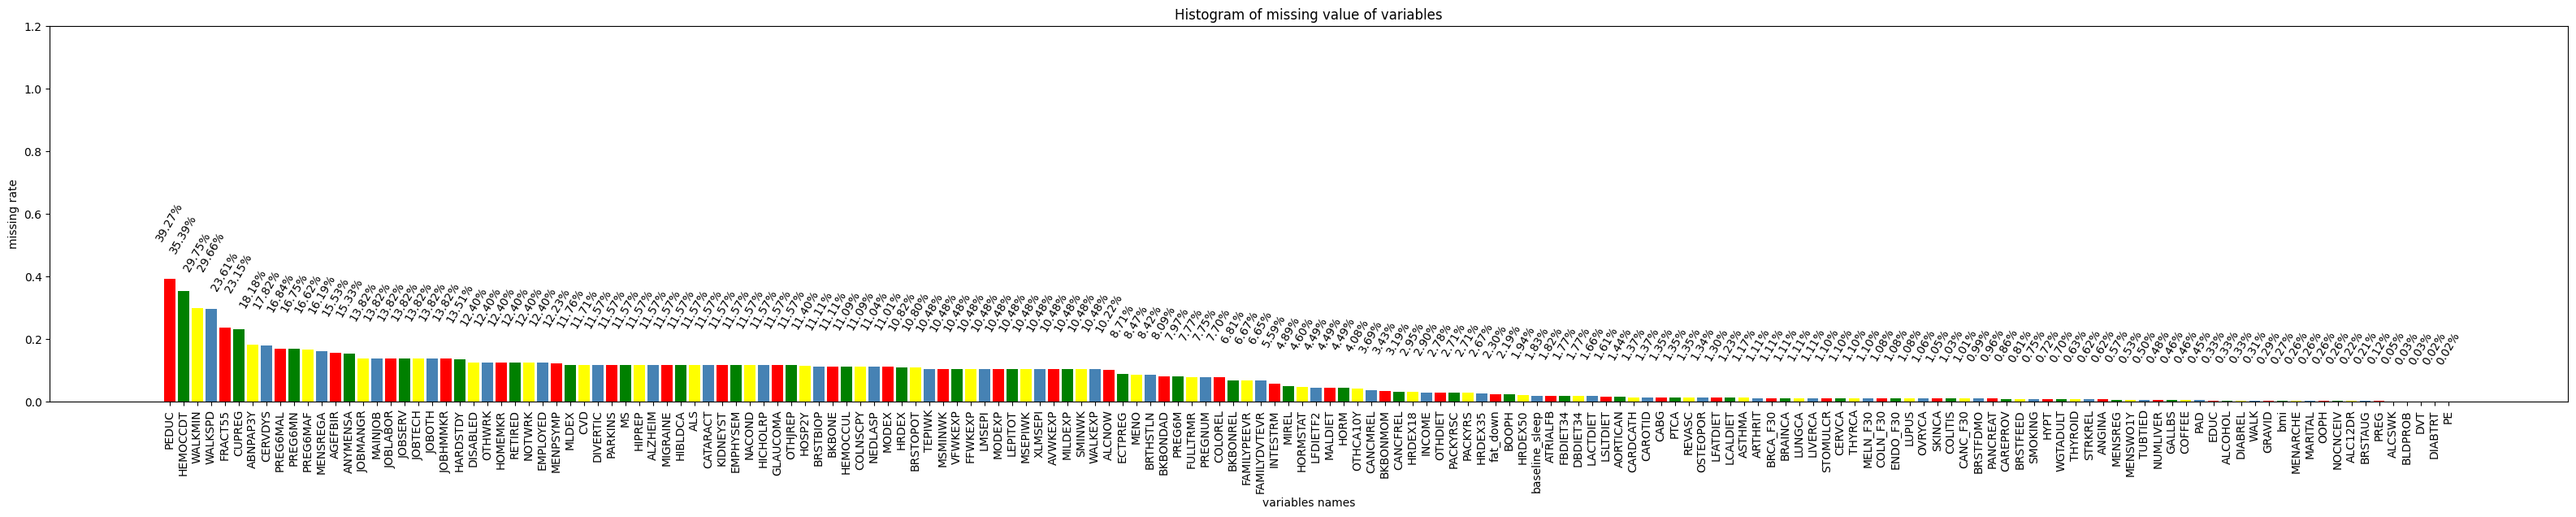

In [23]:
fig = plt.figure(figsize=(40,6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align = 'center',
        color=['red','green','yellow','steelblue'])

plt.title('Histogram of missing value of variables')
plt.xlabel('variables names')
plt.ylabel('missing rate')
# 添加x轴标签，并旋转90度
plt.xticks(np.arange(miss_analy.shape[0]),list(miss_analy['index']))
pl.xticks(rotation=90)
# 添加数值显示
for x,y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x,y+0.12,'{:.2%}'.format(y),ha='center',rotation=60)    
plt.ylim([0,1.2])
    
plt.show()

In [24]:
# 查看缺失值的数据类型，为后续不同类型填充策略做准备
missing = df_update1.columns[df_update1.isnull().any()]
#missing.drop(columns=['subjID','FID','IID'], inplace=True)
missing_df =  df_update1[missing]
#sns.heatmap(corr_matrix, linewidths=0.1, vmax=0.1,square=True,linecolor='white',annot=True)
missing_df.dtypes.value_counts()

float64    156
object      10
dtype: int64

In [ ]:
def HeatMap(df, x=True):
  correlations = df.corr()
  ## creat color map ranging between two colors
  ## diverging_palette()为创建两种颜色过渡色板
  cmap = sns.diverging_palette(100, 10,as_cmap=True)
  fig, ax = plt.subplots(figsize=(35,35))
  ## heatmap中参数: vmin和vmax定义图卡颜色，用于锚定颜色图的值
  # cmap 颜色映射名称或对象; fmt 添加注释时要使用的字符串格式化代码
  #fmt='.2f',当Annot为TRUE时才有用，显示数值的小数点位数
  fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, vmin=-1.0,
                    square=True,linewidths=.05, 
                    annot=False, cbar_kws={'shrink': .25},
                   mask = abs(correlations) <0.9 )
  fig.set_xticklabels(fig.get_xticklabels(), rotation = 90, fontsize = 9)
  fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 9)
  plt.tight_layout()
  plt.show()
HeatMap(missing_df,x=True)

In [71]:
# 查找相关系数> 0.9的列，考虑删除其中一列
missing_cor = missing_df.corr()
sub_missing_cor = []
for index in missing_cor.index:
  for i in range(len(missing_cor.loc[index].values)):
     if((missing_cor.loc[index].values[i] >= 0.9) & (missing_cor.loc[index].values[i]<1)):
 #sub = missing_cor.where((np.abs(missing_cor[i]).isin(0.9,1), print(missing_cor.loc[i,i])))
     #sub_missing_cor.append(sub)
        print(index, i)
        print(missing_cor.loc[index].values[i])

XLMSEPI 140
0.925284670369379
MSMINWK 138
0.925284670369379


In [ ]:
#missing_cor.iloc[1,[74,55,89,101,107,86,97,151,145,146,147,134,141,152,118,148]]
#(HYPT,HTNTRT,PREG6MN,BRTHLIVN,BRSTBIOP,PARITY,NUMLIVER,BRSTDIS,SMOKEVR,HRDEX,LEPITOT,XLMSEPI,SEPIWK,TMINWK,MSMINWK,SMOKING
# HARDEXP,SMINWK,LEPITOT)缺失变量间的关联系数大于0.9,即A变量缺失，B变量也会缺失，需删除其中部分变量

In [ ]:
import missingno as msno
#msno.bar(df_update)

In [ ]:
## deleting variables with missing values higher than 40%
#df_update = (df.drop('baseline_mse', axis = 1))
#missing_variables = df_update.isnull().columns
#missing_variables

In [ ]:
missing_values_table(df_update1)

In [28]:
df_update1[miss_analy['index']].dtypes.value_counts()

float64    156
object      10
dtype: int64

In [29]:
print(df_update1.shape)

(5832, 219)


### 2.1.3 Impute missing values by using MICE

In [30]:
df_update2 = df_update1.replace('amind', np.nan)

In [31]:
df_update3 = df_update2.replace('asian',np.nan)

In [32]:
df_update3.dtypes.value_counts()

float64    176
object      24
int64       14
bool         5
dtype: int64

In [33]:
#将布尔逻辑类型改为数值
for u in df_update3.columns:
  if df_update3[u].dtype == bool:
     df_update3[u]=df_update3[u].astype('int', errors='ignore')

In [34]:
df_update3.dtypes.value_counts()

float64    176
object      24
int64       19
dtype: int64

In [72]:
print(df_update3.shape)
# 打印具有缺失值的列名
missing_variables = df_update3.columns[df_update3.isnull().any()]
df_update3[missing_variables].dtypes.value_counts()

(5832, 219)


float64    156
object      21
dtype: int64

### 将分类变量和连续变量分开填充

In [36]:
## example 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.base import TransformerMixin

mice_imputer = IterativeImputer()

class DataFrameImputer(TransformerMixin):
  def _init_(self):
    """Impute missing values.
     Columns of dype object are imputed with MICE category variables in columns.
     Columns of float types are imputed with MICE continueous variables in columns.
    """
  def fit(self, X, y=None):
      self.fill = pd.Series([X[c].value_counts().index[0]
                                      if  X[c].dtype != np.dtype('float')  else  X[c].mean()  for c in X],
              index = X.columns)
      
      return self

  def transform(self, X, Y=None):
        return X.fillna(self.fill)



In [37]:
# example
data = [
    ['a', 1, 2],
    ['b', 1, 1],
    ['b', 2, 2],
    [np.nan, np.nan, np.nan]
]

X = pd.DataFrame(data)
X.columns = ['ame','sge','weight']
xt = DataFrameImputer().fit_transform(X)
xt

,ame,sge,weight
0,a,1.000000,2.000000
1,b,1.000000,1.000000
2,b,2.000000,2.000000
3,b,1.333333,1.666667


In [38]:
## 区分数据中的数值变量和离散变量
## O_index:   数值变量列名
##C :离散变量列名
def distinguish_Char_Num(DataFrame_data):
  import copy
  m, n = DataFrame_data.shape
  O = []
  C = []
  data = copy.deepcopy(DataFrame_data)
  for i in range(n):
    try:
      if isinstance(data.iloc[0, i], int) or isinstance(data.iloc[0, i], float) or isinstance(data.iloc[0, i],  np.float64)  or isinstance(data.iloc[0, i], np.int64) or isinstance(data.iloc[0, i], np.int32):
          O.append(i)
      elif isinstance(data.iloc[0, i], object):
          C.append(i)
      else:
            raise ValueError("the %d colum of data is ot a umber or object")
    except TypeError as e:
          print(e)
  O_data = copy.deepcopy(data.iloc[:, O])
  C_data = copy.deepcopy(data.iloc[:, C])
  O_index = O_data.columns.tolist()
  C_index = C_data.columns.tolist()
  return O_index, C_index

In [39]:
O_index, C_index = distinguish_Char_Num(df_update3[missing_variables])
# 连续变量 
O_index
# 离散变量
C_index

['ENDO_F2',
 'SKIN_F2',
 'MELAN_F2',
 'OTHCA10Y',
 'HORM',
 'MALDIET',
 'LFDIETF2',
 'DVT',
 'PE',
 'STROKE',
 'TIA',
 'MI',
 'CHF_F2',
 'LIVERDIS',
 'BLDPROB',
 'OTHCHRON',
 'HORMSTAT',
 'DIABTRT']

In [40]:
# 采用IMPUTER 填补 缺失值数据类型为分类变量的数据，填补的方法为填充为类别多的值
class DataFrameImputer(TransformerMixin):
  def _init_(self):
    """Impute missing values.
     Columns of dype object are imputed with MICE category variables in columns.
     Columns of float types are imputed with MICE continueous variables in columns.
    """
  def fit(self, X, y=None):
      self.fill = pd.Series([X[c].value_counts().index[0] 
                      if  X[c].dtype == np.dtype('O') else np.nan for c in X],
              index = X.columns)
      
      return self

  def transform(self, X, Y=None):
        return X.fillna(self.fill)

In [41]:
xt_cata_complete = DataFrameImputer().fit_transform(df_update3)

In [42]:
xt_cata_complete.dtypes.value_counts()

float64    176
object      23
int64       19
bool         1
dtype: int64

In [43]:
missing = missing_values_table(xt_cata_complete)
missing

Your selected dataframe has 219 columns.
There are 156 columns that have missing values.


,Missing Values,% of Total Values
PEDUC,2290,39.3
HEMOCCDT,2064,35.4
WALKMIN,1735,29.7
WALKSPD,1730,29.7
FRACT55,1377,23.6
...,...,...
MARITAL,15,0.3
ALC12DR,13,0.2
BRSTAUG,12,0.2
PREG,7,0.1


In [44]:
# 筛选出缺失值比例< 2%的变量，直接用均值填充
O_index_low = missing[(missing['% of Total Values'] < 2) ].index
print(O_index_low)
for col_name in O_index_low:
      xt_cata_complete[col_name] = xt_cata_complete[col_name].fillna(xt_cata_complete.loc[xt_cata_complete[col_name].isnull() == False, col_name].mean())

Index(['HRDEX50', 'baseline_sleep', 'ATRIALFB', 'FBDIET34', 'DBDIET34',
       'LACTDIET', 'LSLTDIET', 'AORTICAN', 'CARDCATH', 'CAROTID', 'CABG',
       'PTCA', 'REVASC', 'OSTEOPOR', 'LFATDIET', 'LCALDIET', 'ASTHMA',
       'BRCA_F30', 'BRAINCA', 'LUNGCA', 'LIVERCA', 'ARTHRIT', 'THYRCA',
       'CERVCA', 'STOMULCR', 'MELN_F30', 'COLN_F30', 'LUPUS', 'ENDO_F30',
       'OVRYCA', 'SKINCA', 'COLITIS', 'CANC_F30', 'BRSTFDMO', 'PANCREAT',
       'CAREPROV', 'BRSTFEED', 'SMOKING', 'HYPT', 'WGTADULT', 'THYROID',
       'STRKREL', 'ANGINA', 'MENSREG', 'MENSWO1Y', 'TUBTIED', 'NUMLIVER',
       'COFFEE', 'GALLBS', 'PAD', 'DIABREL', 'ALCOHOL', 'EDUC', 'WALK',
       'GRAVID', 'bmi', 'OOPH', 'MENARCHE', 'NOCNCEIV', 'MARITAL', 'ALC12DR',
       'BRSTAUG', 'PREG', 'ALCSWK'],
      dtype='object')


In [45]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
# 方法一：采用固定参数 进行多重插补填充缺失值
#mice_imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=5)

#['insu','ldl','hdl','chol','tg','glu','sbp','dbp',
#variables =  missing_values_table(xt_cata_complete).index
#for i in variables:
#  xt_cata_complete[i] = mice_imputer.fit_transform(xt_cata_complete[[i]])


In [ ]:
X_train.fat_down.value_counts()

In [64]:
X_train[X_train['fat_down'] == "False"] = 0

In [ ]:
# 方法二：创建建模通道，历遍不同参数，看哪个参数的效果最好
from matplotlib import pyplot
#LR_results = list()
LR_AUC_results = list()
#strategies = ['ascending','descending','roman','arabic','random']wertyuiop
strategies = [str(i) for i in range(1,30)]
#strategy = [str[i] for i i rage(1,50)]
for s in strategies: 
#  for s in strategy:
     model = LogisticRegression(solver='newton-cg', class_weight='balanced')
     imputer = IterativeImputer(max_iter=int(s))
     pipeline1 = Pipeline(steps = [('i', imputer), ('m', model)])
     cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=2, random_state=1)
# 评估模型
     scores_auc =  cross_val_score(pipeline1, X_train, y_train,
												 scoring='roc_auc',
												 cv=cv , 
                         n_jobs=-1,
                         error_score = 'raise')
    #LR_results.append(scores)
     LR_AUC_results.append(scores_auc)
     print('>%s %.3f (%.3f)' % (s, mean(scores_auc), std(scores_auc)))

In [ ]:
LR_results

In [ ]:
# 
strategies = ['ascending','descending','roman','arabic','random']

pyplot.boxplot(LR_results, labels=strategies, showmeans=True)
pyplot.xticks(rotation = 45)
pyplot.show()

In [ ]:
X_train.head()

In [ ]:
missing_values_table( xt_cata_complete)

In [47]:
# 删除其他cvd的患病情况
cvd_vars = ['chd','isch_stroke','hemo_stroke','death','cvd_death','non_cvd_death','cancer','cvd_binary']
df_update4= (xt_cata_complete.drop(cvd_vars, axis=1))

In [48]:
df_name = df_update4.columns
df_name

Index(['mi', 'fat_down', 'multi_supp', 'multi_supp_mineral', 'stress_supp',
       'mix_supp', 'SCORE_baseline_sleep_p0.05_0.05', 'sugar_pct',
       'baseline_sugar', 'SCORE_inso_all_group',
       ...
       'VFWKEXP', 'ALCSWK', 'ALCOHOL', 'PACKYRS', 'PACKYRSC', 'FAMILYDVTEVR',
       'FAMILYPEEVR', 'sbp', 'dbp', 'bmi'],
      dtype='object', length=211)

## 2.2 Data visualization
#### let's look at our data in the most raw shape by using scatter plot

In [ ]:
#g = sns.pairplot(df, hue = "mi", diag_kind="hist", palette = "husl")

### 2.2.1 check the example pregenecy distribution

In [40]:
def plotHist(df,nameOfFeature):
    cls_train = df[nameOfFeature]
    data_array = cls_train
    hist_data = np.histogram(data_array)
    binsize = .5

    trace1 = go.Histogram(
        x=data_array,
        name='Histogram of Wind Speed',
        autobinx=False,
        xbins=dict(
            start=df[nameOfFeature].min()-1,
            end=df[nameOfFeature].max()+1,
            size=binsize
        )
    )

    trace_data = [trace1]
    layout = go.Layout(
        bargroupgap=0.3,
         title='The distribution of ' + nameOfFeature,
        xaxis=dict(
            title=nameOfFeature,
            titlefont=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        ),
        yaxis=dict(
            title='Number of labels',
            titlefont=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
    fig = go.Figure(data=trace_data, layout=layout)
    py.iplot(fig)

In [ ]:
plotHist(df_update4,'age')

### 2.2.2 Investagate each feature distribution for each outcome

In [41]:
from scipy.stats import skew
from scipy.stats import kurtosis
## define bar plot
def plotBarCat(df,feature,target):




    x0 = df[df[target]==0][feature]
    x1 = df[df[target]==1][feature]

    trace1 = go.Histogram(
        x=x0,
        opacity=0.75
    )
    trace2 = go.Histogram(
        x=x1,
        opacity=0.75
    )

    data = [trace1, trace2]
    layout = go.Layout(barmode='overlay',
                      title=feature,
                       yaxis=dict(title='Count'
        ))
    fig = go.Figure(data=data, layout=layout)

    py.iplot(fig, filename='overlaid histogram')
## define Describe float skewkurt
    def DescribeFloatSkewKurt(df,target):
        """
            A fundamental task in many statistical analyses is to characterize
            the location and variability of a data set. A further
            characterization of the data includes skewness and kurtosis.
            Skewness is a measure of symmetry, or more precisely, the lack
            of symmetry. A distribution, or data set, is symmetric if it
            looks the same to the left and right of the center point.
            Kurtosis is a measure of whether the data are heavy-tailed
            or light-tailed relative to a normal distribution. That is,
            data sets with high kurtosis tend to have heavy tails, or
            outliers. Data sets with low kurtosis tend to have light
            tails, or lack of outliers. A uniform distribution would
            be the extreme case
        """
        print('-*-'*25)
        print("{0} mean : ".format(target), np.mean(df[target]))
        print("{0} var  : ".format(target), np.var(df[target]))
        print("{0} skew : ".format(target), skew(df[target]))
        print("{0} kurt : ".format(target), kurtosis(df[target]))
        print('-*-'*25)
    
    DescribeFloatSkewKurt(df,target)

In [ ]:
plotBarCat(df_update,df_name[0],'mi')

In [ ]:
plotBarCat(df,df_name[1],'mi')

In [ ]:
plotBarCat(df,df_name[2],'mi')

In [ ]:
plotBarCat(df,df_name[3],'mi')

In [ ]:
plotBarCat(df,df_name[4],'mi')

In [ ]:
plotBarCat(df,df_name[5],'mi')

In [ ]:
plotBarCat(df,df_name[6],'mi')

In [ ]:
plotBarCat(df,df_name[7],'mi')

In [ ]:
plotBarCat(df,df_name[8],'mi')

### 2.2.3 pie plot to check the proportion of outcome

In [ ]:
def PlotPie(df, nameOfFeature):
    labels = [str(df[nameOfFeature].unique()[i]) for i in range(df[nameOfFeature].nunique())]
    values = [df[nameOfFeature].value_counts()[i] for i in range(df[nameOfFeature].nunique())]

    trace=go.Pie(labels=labels,values=values)

    py.iplot([trace])

In [ ]:
PlotPie(df_update4, 'mi')

## 2.3 Outlier investigation

In [ ]:
def OutLiersBox(df, nameOfFeature):
  trace0 = go.Box(
        y = df[nameOfFeature],
        name = "All Points",
        jitter = 0.3,
        pointpos = -1.8,
        boxpoints = 'all',
        marker = dict(
            color = 'rgb(7,40,89)'),
        line = dict(
            color = 'rgb(7,40,89)')
    )

  trace1 = go.Box(
        y = df[nameOfFeature],
        name = "Only Whiskers",
        boxpoints = False,
        marker = dict(
            color = 'rgb(9,56,125)'),
        line = dict(
            color = 'rgb(9,56,125)')
    )

  trace2 = go.Box(
        y = df[nameOfFeature],
        name = "Suspected Outliers",
        boxpoints = 'suspectedoutliers',
        marker = dict(
            color = 'rgb(8,81,156)',
            outliercolor = 'rgba(219, 64, 82, 0.6)',
            line = dict(
                outliercolor = 'rgba(219, 64, 82, 0.6)',
                outlierwidth = 2)),
        line = dict(
            color = 'rgb(8,81,156)')
    )

  trace3 = go.Box(
        y = df[nameOfFeature],
        name = "Whiskers and Outliers",
        boxpoints = 'outliers',
        marker = dict(
            color = 'rgb(107,174,214)'),
        line = dict(
            color = 'rgb(107,174,214)')
    )

  data = [trace0,trace1,trace2,trace3]

  layout = go.Layout(
        title = "{} Outliers".format(nameOfFeature)
    )

  fig = go.Figure(data=data,layout=layout)
  py.iplot(fig, filename = "Outliers")

In [ ]:
OutLiersBox(df_update,df_name[0])

### 2.3.1 Outliers investigation pairs

In [50]:
df_update4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5832 entries, 1 to 16581
Columns: 211 entries, mi to bmi
dtypes: bool(1), float64(176), int64(11), object(23)
memory usage: 9.4+ MB


In [49]:
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# define outlier detection methods

def OutLierDetection(df,feature1,feature2,outliers_fraction=.1):
    
    new_df = df.copy()
    # 设置随机数字
    rng = np.random.RandomState(42)

    # Example settings
    n_samples = new_df.shape[0]
#     outliers_fraction = 0.2 # ************************************** imp
    clusters_separation = [0]#, 1, 2]

    # define two outlier detection tools to be compared
    # 采用四种方法检测异常值
    classifiers = {
        "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                         kernel="rbf", gamma=0.1),
        "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
        "Isolation Forest": IsolationForest(max_samples=n_samples,
                                            contamination=outliers_fraction,
                                            random_state=rng),
        "Local Outlier Factor": LocalOutlierFactor(
            n_neighbors=35,
            novelty=True,
            contamination=outliers_fraction)}

    # meshgrid 函数用两个坐标轴上的点在平面上画网格
    # linspace 用来创建等差数列
    xx, yy = np.meshgrid(np.linspace(new_df[feature1].min()-new_df[feature1].min()*10/100, 
                                     new_df[feature1].max()+new_df[feature1].max()*10/100, 50),
                         np.linspace(new_df[feature2].min()-new_df[feature2].min()*10/100,
                                     new_df[feature2].max()+new_df[feature2].max()*10/100, 50))

    # 计算在正常值范围内 inliers 和异常值 outliers 的 sample 数量
    n_inliers = int((1. - outliers_fraction) * n_samples)
    n_outliers = int(outliers_fraction * n_samples)
    # np.ones()函数返回给定形状和数据类型的新数组
    ground_truth = np.ones(n_samples, dtype=int)
    ground_truth[-n_outliers:] = -1

    # Fit the problem with varying cluster separation
    # enumerate 迭代对象
    for i, offset in enumerate(clusters_separation):
        np.random.seed(42)
        # Data generation
    # value.tolist将data_frame 转换为 list形式
        X = new_df[[feature1,feature2]].values.tolist()

        # Fit the model
        plt.figure(figsize=(9, 7))
        for i, (clf_name, clf) in enumerate(classifiers.items()):
            # fit the data and tag outliers
            if clf_name == "Local Outlier Factor":
                y_pred = clf.fit(X).predict(X)
                scores_pred = clf.negative_outlier_factor_
            else:
                clf.fit(X)
                scores_pred = clf.decision_function(X)
                y_pred = clf.predict(X)
            threshold = stats.scoreatpercentile(scores_pred,
                                                100 * outliers_fraction)
            n_errors = (y_pred != ground_truth).sum()
            
            unique, counts = np.unique(y_pred,return_counts=True)
            print(clf_name,dict(zip(unique, counts)))
            
            new_df[feature1+'_'+feature2+clf_name] = y_pred
#             print(clf_name,y_pred) 
            # plot the levels lines and the points
            if clf_name == "Local Outlier Factor":
                # decision_function is private for LOF
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
              # .decision_function 为机器学习框架的分类器类,计算样本点到分割超平面的函数距离
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
              # .reshape可转变数组的形状，转为二维或者三维数组
            Z = Z.reshape(xx.shape)
            # subplot 可绘制多图
            subplot = plt.subplot(2, 2, i + 1)
            # countour & countourf 为生成等线图
            subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                             cmap=plt.cm.Blues_r)
            # plt.cm.Blues_r为python内置颜色映射
            a = subplot.contour(xx, yy, Z, levels=[threshold],
                                linewidths=2, colors='red')
            subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                             colors='orange')
            b = plt.scatter(new_df[feature1], new_df[feature2], c='white',
                     s=20, edgecolor='k')

            subplot.axis('tight')

            subplot.set_xlabel("%s" % (feature1))
            # %s 运算符放在要指定字符串的位置。要附加到字符串的值的数量应等于字符串值末尾 % 运算符后括号中指定的数量
            plt.ylabel(feature2)#, fontsize=18)
            plt.title("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
            # %d 运算符放在要指定整数的位置。浮点数会自动转换为十进制值。
        plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
#         plt.suptitle("Outlier detection")

    plt.show()
    return new_df

In [ ]:
tt = OutLierDetection(df_update4,'age','bmi',.1)

## 3 Feature engineeing 

### 3.1 Evaluate Algorithms: Baseline

In [51]:
# Load libraries
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler

### 3.1.1 make train-validation and test data sets

In [52]:
#,'chd','isch_stroke','hemo_stroke','cvd_binary', 'SCORE_inso_all_group'
#df_update4.drop(columns=['time_to_ad'], inplace=True)
df_update4['mi'].value_counts()

0    5437
1     395
Name: mi, dtype: int64

In [ ]:
df_update4.head()

In [54]:
df_name=df_update4.columns

In [55]:
df_update4.to_csv('pheno.prs.0513.csv', sep="\t", index = False)

In [ ]:
df_updata4 = pd.read_csv('pheno.prs.0513.csv', sep="\t")

In [57]:
X = df_update4[df_name[1:210]]
Y = df_update4[df_name[0]]
X_train, X_test, y_train, y_test = train_test_split(
    X,Y,
    test_size=0.3,
    random_state=0,
    stratify=Y
)
# train 和 test 分布不平衡的情况会 用到stratify参数，按照x 或者 y 调整平衡分布
# 将stratify=X就是按照X中的比例分配 
# 将stratify=y就是按照y中的比例分配

In [57]:
X_train.head(10)

,fat_down,multi_supp,multi_supp_mineral,stress_supp,mix_supp,SCORE_baseline_sleep_p0.05_0.05,sugar_pct,baseline_sugar,SCORE_inso_all_group,baseline_sleep,baseline_tot_cal,baseline_fat,baseline_pro,baseline_cho,baseline_sfa,baseline_mufa,baseline_pufa,baseline_alc,baseline_palm,baseline_n3,hei,myhei,age,BRCA_F2,COLON_F2,ENDO_F2,SKIN_F2,MELAN_F2,OTHCA10Y,HORM,HYST,MALDIET,LFDIETF2,DVT,PE,STROKE,TIA,MI,SCANEMIA,CHF_F2,LIVERDIS,BLDPROB,L15LBS6M,DIALYSIS,OTHCHRON,HARDSTDY,COMECC,HORMSTAT,DIABTRT,dm_intervention,ht_trial,ht_intervention,cad_trial,cad_intervention,EDUC,NOTWRK,RETIRED,HOMEMKR,EMPLOYED,DISABLED,OTHWRK,JOBHMMKR,JOBMANGR,JOBTECH,JOBSERV,JOBLABOR,JOBOTH,MARITAL,PEDUC,INCOME,CAREPROV,ABNPAP3Y,CERVDYS,MAINJOB,HOSP2Y,GLAUCOMA,CATARACT,HICHOLRP,ASTHMA,EMPHYSEM,KIDNEYST,HIBLDCA,STOMULCR,DIVERTIC,COLITIS,LUPUS,PANCREAT,OSTEOPOR,HIPREP,OTHJREP,...,SKINCA,MELN_F30,LIVERCA,LUNGCA,BRAINCA,BKBONE,FRACT55,REVASC,MENARCHE,MENSREG,MENSREGA,MENSWO1Y,ANYMENSA,MENPSYMP,PREG,PREGNUM,PREG6M,PREG6MN,PREG6MAF,PREG6MAL,BRTHSTLN,ECTPREG,NOCNCEIV,BRSTFEED,OOPH,TUBTIED,NEDLASP,BRSTBIOP,BRSTAUG,BRSTOPOT,GRAVID,FULLTRMR,NUMLIVER,AGEFBIR,BOOPH,BRSTFDMO,BRSTDIS,MENO,DIABREL,MIREL,STRKREL,CANCFREL,CANCMREL,BKBONMOM,BKBONDAD,BKBONREL,COLOREL,COFFEE,CUPREG,ALC12DR,ALCNOW,WGTADULT,LCALDIET,LFATDIET,LSLTDIET,FBDIET34,DBDIET34,LACTDIET,OTHDIET,WALK,WALKMIN,WALKSPD,HRDEX,MODEX,MLDEX,HRDEX18,HRDEX35,HRDEX50,TEPIWK,LEPITOT,MSEPIWK,XLMSEPI,LMSEPI,MSMINWK,SMINWK,WALKEXP,SMOKING,MODEXP,MILDEXP,AVWKEXP,FFWKEXP,VFWKEXP,ALCSWK,ALCOHOL,PACKYRS,PACKYRSC,FAMILYDVTEVR,FAMILYPEEVR,sbp,dbp
4269,True,0,0,0,0,546.264,0.217796,113.75689,0.000192,5.0,2089.23406,76.66105,91.04862,270.58376,24.481930,27.58245,18.16944,0.05497,13.22266,2.07113,72.87202,0.001299,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,1,1,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN,1.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,6.0,0.0,41.0,0.0,1.0,4.0,1.0,4.0,1.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0,1.0,0.0,0.0,41.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0,0.0,2.0,0.0,1.0,1.0,0.00000,4.5,0.0,2.0,0.0,2.0,20.0,0.0,1.875,1.0,1.50,0.0,1.875,0.0,0.0,0.00000,2.0,1.250,1.0,0.0,0.0,130.0,83.0
3158,True,0,0,0,0,551.828,0.144485,50.52879,0.000205,16.0,1398.86921,73.84144,64.59969,122.89398,26.155750,28.35619,12.91019,0.00612,14.06495,1.66335,51.99235,-0.003924,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,1,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,5.0,6.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,4.0,0.0,35.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,1.0,35.0,9.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,NaN,1.0,0.34534,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000,0.0,0.00,0.0,0.000,0.0,0.0,0.00000,3.0,0.000,0.0,0.0,0.0,138.0,97.0
11335,False,0,0,0,0,545.801,0.381827,61.60022,0.000190,5.0,645.32020,22.15401,19.30198,96.39592,7.393980,8.34368,4.90932,0.42027,3.90170,0.54824,69.51152,-0.007644,72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,NaN,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,7.0,0.0,56.0,1.0,1.0,2.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,60.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,3.0,0.0,0.0,0.0,1.0,1.0,0.00000,5.0,5.0,0.0,0.0,2.0,0.0,0.0,7.500,0.0,0.00,0.0,7.500,0.0,0.0,0.21154,4.0,0.000,0.0,0.0,0.0,11

In [ ]:
y_train.head()

4269     0
3158     0
11335    0
6495     0
4339     0
Name: mi, dtype: int64

In [ ]:
sum(y_train == 1)
print("There are {} training samples".format(y_train.shape[0]))
print("There are {} testing samples".format(X_test.shape[0]))

There are 2231 training samples
There are 957 testing samples


## 3.2 Feature selection(选择特征)

### 3.2.1 单变量特征选择(univariate feature selection)

In [ ]:
# 卡方(chi2)检验
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
print(X.shape)
print(X.isna().sum())
print(Y.head())

In [ ]:
num_list = (df < 0).astype(int).sum()
num_list

In [ ]:
X_update = X.drop(['delta_sleep','delta_ces_d'], axis=1)

In [ ]:
# X 需要为非负数，因此，此步骤删除delta_sleep, delta_ces_d
X_new = SelectKBest(chi2, k = 20).fit_transform(X_update, Y)
print(X_new.shape)

(5832, 20)


In [ ]:
# 选择相关特征后再一次划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X_new,Y,
    test_size=0.3,
    random_state=0,
    stratify=Y
)
# train 和 test 分布不平衡的情况会 用到stratify参数，按照x 或者 y 调整平衡分布
# 将stratify=X就是按照X中的比例分配 
# 将stratify=y就是按照y中的比例分配

In [ ]:
sum(y_train == 1)
print("There are {} training samples".format(y_train.shape[0]))
print("There are {} testing samples".format(X_test.shape[0]))

There are 4082 training samples
There are 1750 testing samples


### 3.2.2 基于模型的特征排序(model based ranking)

In [ ]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
rf_feature = RandomForestRegressor(n_estimators=20, max_depth=4)
scores=[]

# 单独采用每个特征进行建模，并交叉验证
for i in range(X.shape[1]):
  score = cross_val_score(rf_feature, X.iloc[:, i:i+1], Y, scoring='r2', cv=ShuffleSplit(n_splits=10, test_size=0.3, random_state=3))
  # 注意X[:,i]shape(1,m)和x[:,i:i+1]的区别
  scores.append((format(np.mean(score), '.3f'), df_name[i]))
print(sorted(scores, reverse=True))

[('0.025', 'FRACT55'), ('0.022', 'CABG'), ('0.015', 'CARDCATH'), ('0.013', 'FBDIET34'), ('0.011', 'THYROID'), ('0.011', 'PTCA'), ('0.009', 'BKBONE'), ('0.008', 'dm_intervention'), ('0.008', 'HYPT'), ('0.005', 'myhei'), ('0.005', 'NACOND'), ('0.005', 'CATARACT'), ('0.004', 'FAMILYPEEVR'), ('0.003', 'CVD'), ('0.002', 'NOTWRK'), ('0.002', 'HOMEMKR'), ('0.002', 'FULLTRMR'), ('0.002', 'ALS'), ('0.001', 'JOBSERV'), ('0.001', 'JOBOTH'), ('0.001', 'JOBHMMKR'), ('0.001', 'GRAVID'), ('0.001', 'COFFEE'), ('0.000', 'fat_down'), ('0.000', 'WALK'), ('0.000', 'MAINJOB'), ('0.000', 'LFATDIET'), ('0.000', 'LCALDIET'), ('0.000', 'LACTDIET'), ('0.000', 'KIDNEYST'), ('0.000', 'BRSTOPOT'), ('0.000', 'BKBONREL'), ('-0.015', 'mix_supp'), ('-0.015', 'baseline_pufa'), ('-0.014', 'baseline_tot_cal'), ('-0.014', 'baseline_palm'), ('-0.013', 'SMINWK'), ('-0.012', 'baseline_n3'), ('-0.012', 'TMINWK'), ('-0.012', 'TEPIWK'), ('-0.012', 'HRDEX50'), ('-0.011', 'baseline_sugar'), ('-0.011', 'baseline_sfa'), ('-0.011', 

### 3.2.3 递归特征消除(wrapper: recursive feature elimination)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# 递归特征消除法，返回特征选择后的数据
# 参数estimator为基模型，n_features_to_select为选择的特征数
RFE(estimator=LogisticRegression(), n_features_to_select=2).fit_transform(X, Y)

### 3.2.4 基于L1的特征选择(Embedding: feature selection using SelectFromModel)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
# 对于SVM和罗辑回归，参数C控制稀疏性，C越小，被选中的特征越少，对于lasso，参数alpha越大，被选中的特征越少
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(X,Y)
# 
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape

(3188, 90)

#### 选择特征后再次划分数据集

In [ ]:
# 选择相关特征后再一次划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X,Y,
    test_size=0.3,
    random_state=0,
    stratify=Y
)
# train 和 test 分布不平衡的情况会 用到stratify参数，按照x 或者 y 调整平衡分布
# 将stratify=X就是按照X中的比例分配 
# 将stratify=y就是按照y中的比例分配

### 3.2.5 基于树的特征选择(tree-based feature selection)

### 3.2.5.1基于extratreeclassifier的特征选择

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
# 
clf = ExtraTreesClassifier()
clf = clf.fit(X, Y)
clf.feature_importances_
#
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape

(3188, 121)

### 3.2.5.2基于decision tree classifier/classification and regression trees(CART)的特征选择

In [ ]:
# load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [ ]:
# Building Decision Tree Model
# create Decision Tree classifer object
Tree = DecisionTreeClassifier(random_state=0)

# train decision tree classifer
Tree.fit(X_train, y_train)
features = X_train.columns

In [ ]:
# 交叉验证评估
score1 = cross_val_score(Tree, X_train, y_train, cv = 5).mean()
score2 = Tree.score(X_test, y_test)
print(score1)
print(score2)

0.859701447617901
0.8589341692789969


In [ ]:
# 查看数据集分布是否平衡，如不平衡，可以采用sample_weight设置
y_train.value_counts()

0    2074
1     157
Name: mi, dtype: int64

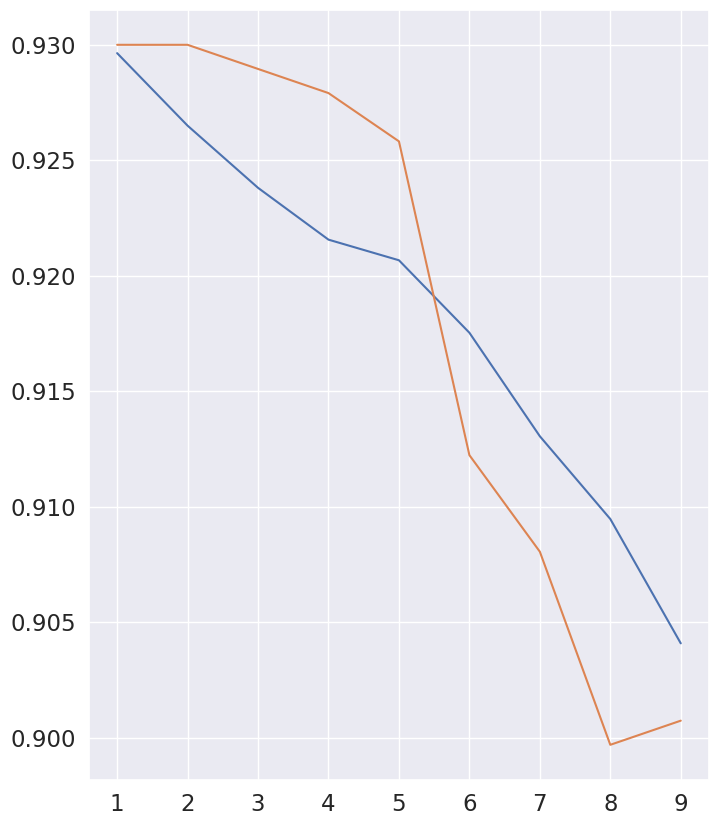

In [ ]:
## 选择1：尝试改变树的深度，模型的表现是否有改变
cvs_score = []
test_score = []
for i in range(1,10):
  Tree = DecisionTreeClassifier(random_state=0, max_depth=i)
  Tree = Tree.fit(X_train, y_train)
  cvs_score.append(cross_val_score(Tree, X_train, y_train, cv = 5).mean())
  test_score.append(Tree.score(X_test, y_test))
# 绘图查看最佳深度
plt.plot(range(1,10), cvs_score) # 深度在1的时候表现最好
plt.plot(range(1,10), test_score)

In [ ]:
# 选择2: 采用网格搜索调整参数
param = {'max_depth':[*range(1,10)],
         'splitter':('best','random'),
         'criterion':('gini','entropy'),
         'min_impurity_decrease':[*np.linspace(0,0.5,20)],
         'min_samples_leaf':[*range(1,50,5)] # 2
         }
Tree = DecisionTreeClassifier(random_state=0)
GS = GridSearchCV(Tree, param, cv=5)
GS.fit(X_train, y_train)
print(GS.best_params_)
print(GS.best_score_)

{'criterion': 'entropy', 'max_depth': 6, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 16, 'splitter': 'random'}
0.9300769454560047


In [ ]:
# 最优参数得分如下
score2 = GS.score(X_test,y_test)
score2

0.9299895506792059

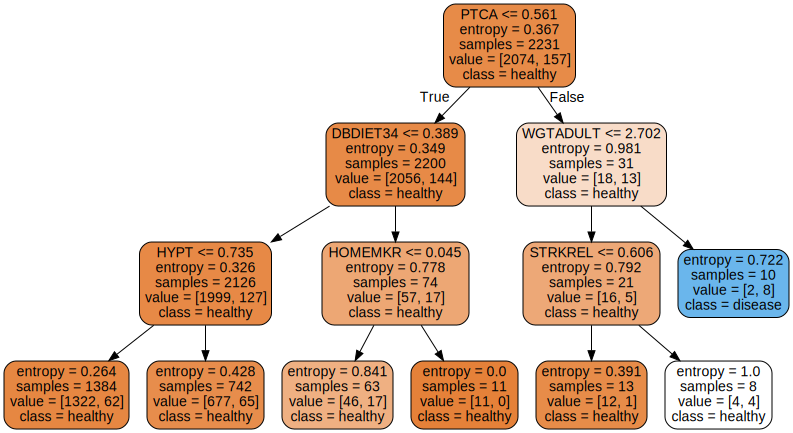

In [ ]:
# 可视化决策树
from sklearn import tree
import graphviz
Tree = DecisionTreeClassifier(random_state=0, criterion='entropy',max_depth=3,min_impurity_decrease=0,min_samples_leaf=6,splitter='random')
Tree.fit(X_train, y_train)
feature_name = X_train.columns.tolist()
dot_data = tree.export_graphviz(Tree,
                                out_file = None,
                                feature_names = feature_name,
                                class_names=['healthy','disease'],
                                filled=True,
                                rounded=True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
# DBDIET34, REVASC, ANGINA, ht_trial, LCALDIET, HEMOCCDT, MSMINWK,SCORE_baseline_sleep_p0.05_0.05

The f1 score for the testing data: 0.0
Classfication report: 
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      1400
         1.0       0.00      0.00      0.00       104

    accuracy                           0.93      1504
   macro avg       0.47      0.50      0.48      1504
weighted avg       0.87      0.93      0.90      1504



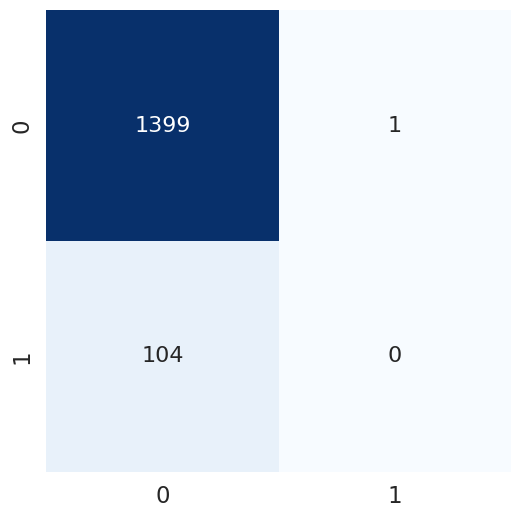

In [ ]:
# 
Tree.fit(X_train[['DBDIET34', 'REVASC', 'ANGINA', 'ht_trial', 'LCALDIET', 'HEMOCCDT', 'MSMINWK','SCORE_baseline_sleep_p0.05_0.05']], y_train)
# 测试数据预测
pred_test = Tree.predict(X_test[['DBDIET34', 'REVASC', 'ANGINA', 'ht_trial', 'LCALDIET', 'HEMOCCDT', 'MSMINWK','SCORE_baseline_sleep_p0.05_0.05']])

#计算并打印f1分数
f1_test = f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)


# 调用函数
print('Classfication report: \n', classification_report(y_test, pred_test))
conf_matrix(y_test, pred_test)


### 3.2.5.3 采用简便方法(不调参数)排列特征的重要性

In [ ]:
from sklearn.tree import DecisionTreeRegressor
DecisionTreeRegressor()

DecisionTreeRegressor()

In [ ]:
# Building Decision Tree Model
# create Decision Tree classifer object
Tree = DecisionTreeClassifier(random_state=0)

# train decision tree classifer
Tree.fit(X_train, y_train)
features = X_train.columns

print(Tree.feature_importances_)

In [ ]:
print('feature'+'\t'+'importancess')
for i in range(len(features)):
  print('%s\t%.5f'%(features[i], Tree.feature_importances_[i]))

In [ ]:
# 构建排序后的特征
sortindex = np.argsort(Tree.feature_importances_)[::-1]
for i in sortindex:
  if Tree.feature_importances_[i] > 0:
      print('%s\t%.5f'%(features[i], Tree.feature_importances_[i]))

### 3.2.5.4 采用自建函数方式进行决策树分类

In [ ]:
## 自建函数 选择特征
from math import log
from collections import Counter
import numpy as n_splits

In [ ]:
featList = X_train.columns
X_train.shape

(3508, 225)

In [ ]:
# 基尼系数最优化分
def calGini(y_train):
  counter = Counter(y_train.flatten())
  gini = 1
  for num in counter.values():
    p = num / len(y_train)
    gini -= p**2
  return gini
#
def split(X,Y,featVec, value):
  index_a = (X_train[:, featVec] <= value)
  index_b = (X_train[:, featVec] > value)
  return X_train[index_a], X_train[index_b], y_train[index_a], y_train[index_b]

In [ ]:
# 寻找最优划分
def try_split(X_train, y_train):
  bestGini = float('inf')
  bestFeatVec = -1
  bestValue = -1
  # 遍历每一个特征维度（列）
  for featVec in range(X_train.shape[1]):
    sort_index = np.argsort(X_train[:,featList])
    for i in range(1, len(X_train)):
      if X_train[sort_index[i-1], featVec] != X_train[sort_index[i], featVec]:
        value = (X_train[sort_index[i-1], featVec] + X_train[sort_index[i], featVec]) / 2
        X_l, X_r, y_l, y_r = split(X_train, y_train, featVec, value)
        gini = calGini(y_l) + calGini(y_r)
        if gini < bestGini:
          bestGini, bestFeatVec, bestValue = gini, featVec, value
  return bestGini, bestFeatVec, bestValue

In [ ]:
## 2023-04-23 该部分代码跑不出来
bestGini, bestFeatVec, bestValue = try_split(X_train, y_train)
print("最优基尼系数:", bestGini)
print("在哪个维度上进行划分:", bestFeatVec)
print("在哪个值上进行划分:", bestValue)

### 3.2.6 基于lasso的特征选择



###3.2.6.1采用lasso第一种代码(未跑出结果)

In [ ]:
# 参考链接：https://towardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

In [ ]:
# 选择特征前划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X,Y,
    test_size=0.3,
    random_state=0,
    stratify=Y
)
# train 和 test 分布不平衡的情况会 用到stratify参数，按照x 或者 y 调整平衡分布
# 将stratify=X就是按照X中的比例分配 
# 将stratify=y就是按照y中的比例分配

In [ ]:
# 定义特征名称
features = X_train.columns
features

Index(['fat_down', 'multi_supp', 'multi_supp_mineral', 'stress_supp',
       'mix_supp', 'SCORE_baseline_sleep_p0.05_0.05', 'sugar_pct',
       'baseline_sugar', 'SCORE_inso_all_group', 'baseline_sleep',
       ...
       'FFWKEXP', 'VFWKEXP', 'ALCSWK', 'ALCOHOL', 'PACKYRS', 'PACKYRSC',
       'FAMILYDVTEVR', 'FAMILYPEEVR', 'sbp', 'dbp'],
      dtype='object', length=220)

In [ ]:
# 创建model，选择最优高参，并在训练集中训练
pipeline = Pipeline([
               ('scaler', StandardScaler()),
               ('model', Lasso())
])
# 采用girdsearchcv寻找最佳高参
search = GridSearchCV(pipeline,
                      {'model__alpha': np.arange(0.1,10,0.1)},
                      cv = 5,
                      scoring='neg_mean_squared_error',verbose=3)
# 采用neg_mean_square_error是因为网格搜索试图最大化性能指标，因此添加一个符号来最小化均方误差

In [ ]:
search.fit(X_train, y_train)
search.best_params_

In [ ]:
# 获取模型各个变量的系数
coefficients = search.best_estimator_.named_steps['model'].coef_

In [ ]:
# 将各个特征的importance转为正数
importance = np.abs(coefficients)
importance

In [ ]:
# 打印lasso模型中，特征系数>0的特征
np.array(features)[importance == 0]

### 3.2.6.2采用lasso的另外一个代码(跑出结果)

In [ ]:
#参考链接：https://www.kaggle.com/code/aaron7sun/you-got-this-feature-engineering-and-lasso
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5))
    return(rmse)

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], selection='random', max_iter=15000).fit(X_train, y_train)
res = rmse_cv(model_lasso)
print("Mean:",res.mean())
print("Min: ",res.min())

Mean: 0.2542563491009248
Min:  0.2350180614543189


In [ ]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 8 variables and eliminated the other 212 variables


In [ ]:
feature1= coef.sort_values().head(20).index
feature1

Index(['MSMINWK', 'baseline_cho', 'PREGNUM', 'PREG6M', 'PREG6MN', 'PREG6MAF',
       'PREG6MAL', 'BRTHLIVN', 'BRTHSTLN', 'ECTPREG', 'NOCNCEIV', 'BRSTFEED',
       'PREG', 'fat_down', 'TUBTIED', 'NEDLASP', 'BRSTBIOP', 'BRSTAUG',
       'BRSTOPOT', 'GRAVID'],
      dtype='object')

In [ ]:
feature2=coef.sort_values().tail(50).index

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

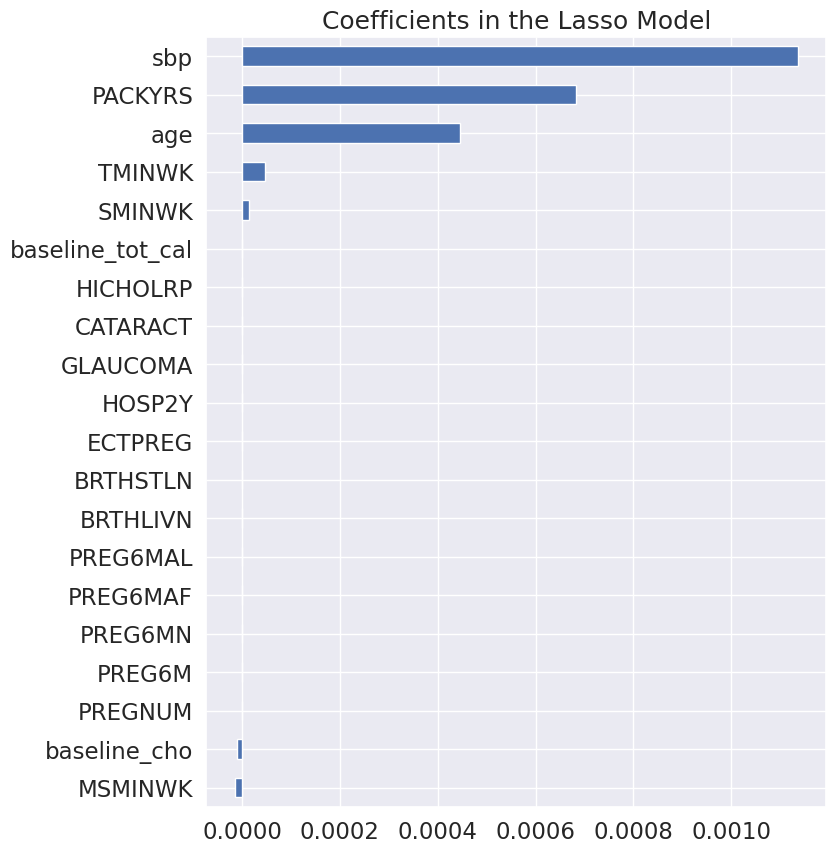

In [ ]:
# plotting feature importances
imp_coef = pd.concat([coef.sort_values().head(10),
                      coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8,10)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

## 3.2 Methods for unbalanced data(处理数据不平衡)

### 3.2.1 SMOTE to deal with unbalanced dataset

#### 查看数据分布

In [ ]:
from collections import Counter
# 查看所生成的样本类别分布，查看0和1样本比例
print(Counter(Y))

Counter({0: 4473, 1: 1359})


#### smote算法核心语句

In [ ]:
# 使用imlbearn库中上采样方法中的smote接口
from imblearn.over_sampling import SMOTE
# 定义smote模型
smo = SMOTE(random_state = 42)
X_train_smo, y_train_smo = smo.fit_resample(X_train,y_train)

In [ ]:
print(Counter(y_train_smo))

Counter({0: 3131, 1: 3131})


In [ ]:
X.head(10)

In [ ]:
Y.head(10)

### 3.2.1 采用权重改善类别不平衡

#### 1) 原始数据集的预测效果评估

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# 导入和训练模型
lr = LogisticRegression(solver='newton-cg', class_weight="balanced")

# 对训练数据集进行标准化
ss = StandardScaler()
X_trian = ss.fit_transform(X_train)
lr.fit(X_train, y_train)

# 测试数据预测
pred_test = lr.predict(X_test)

#计算并打印f1分数
f1_test = f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)

The f1 score for the testing data: 0.152958152958153


Classfication report: 
               precision    recall  f1-score   support

           0       0.94      0.68      0.79      1631
           1       0.09      0.45      0.15       119

    accuracy                           0.66      1750
   macro avg       0.52      0.56      0.47      1750
weighted avg       0.89      0.66      0.75      1750



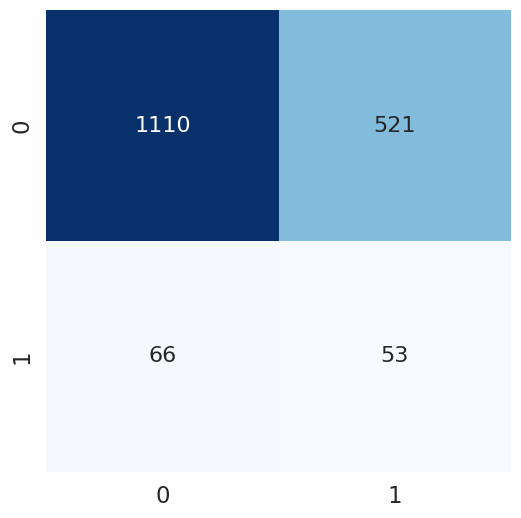

In [ ]:
# 创建混淆矩阵的函数
def conf_matrix(y_test, pred_test):
  # 创建混淆矩阵
  con_mat = confusion_matrix(y_test, pred_test)
  con_mat = pd.DataFrame(con_mat, range(2), range(2))

  plt.figure(figsize=(6,6))
  sns.set(font_scale=1.5)
  sns.heatmap(con_mat, annot=True, annot_kws={'size':16}, fmt='g',cmap='Blues', cbar=False)

# 调用函数
print('Classfication report: \n', classification_report(y_test, pred_test))
conf_matrix(y_test, pred_test)

#### 2) 采用固定权重参数 class_weight='balanced' 调整数据不平衡

In [ ]:
print(feature1)
print(feature2)
feature3 = ['NOTWRK', 'CANCMREL', 'HRDEX35', 'baseline_palm', 'EMPHYSEM', 'TUBTIED',
       'ALCSWK', 'CANCFREL', 'WALKMIN', 'BKBONREL', 'PREG6MAL', 'BRSTFDN',
       'BRSTFDMO', 'baseline_fat', 'LFATDIET', 'HEMOCCDT', 'CATARACT',
       'COFFEE', 'MILDEXP', 'INCOME',
        'SCORE_baseline_sleep_p0.05_0.05', 'MODEX', 'baseline_sugar', 'FFWKEXP',
       'PACKYRS', 'baseline_tot_cal', 'BRSTBIOP', 'HICHOLRP', 'NACOND',
       'ANYMENSA', 'FAMILYDVTEVR', 'MENPSYAL', 'BRSTFDAF', 'FAMILYPEEVR',
       'CARDCATH', 'age', 'DIABREL', 'sbp', 'dm_intervention', 'baseline_pufa',
       'baseline_sfa', 'MENSREGA', 'EMPLOYED', 'cad_trial', 'CUPREG',
       'LEPITOT', 'MIREL', 'PREG6MAF', 'MENSREG', 'CERVDYS', 'BRTHLIVN',
       'SMOKING', 'cad_intervention', 'GALLBS', 'NUMLIVER', 'HIBLDCA',
       'BRSTOPOT', 'HRDEX18', 'OOPH', 'MLDEX', 'WALKSPD', 'HTNTRT', 'fat_down',
       'CVD', 'ANGINA', 'ht_trial', 'COLOREL', 'CABG', 'DBDIET34', 'REVASC']

In [ ]:
# 根据前期特征选择，重新划分数据集
X = df_update4.filter(feature3)
Y = df_update4[df_name[0]]
X_train, X_test, y_train, y_test = train_test_split(
    X,Y,
    test_size=0.3,
    random_state=0,
    stratify=Y
)
# train 和 test 分布不平衡的情况会 用到stratify参数，按照x 或者 y 调整平衡分布
# 将stratify=X就是按照X中的比例分配 
# 将stratify=y就是按照y中的比例分配

In [ ]:
y_train.head()

4269     0.0
3158     0.0
11335    0.0
6495     0.0
4339     0.0
Name: mi, dtype: float64

In [ ]:
# Calculate weights using sklearn


class_weight = 'balanced'
classes = np.array([0, 1])  #标签类别
sklearn_weights = compute_class_weight(class_weight = class_weight, classes = classes, y=y_train)
print(sklearn_weights)

# Compare the values
print(f'The weights for the majority class is {sklearn_weights[0]*2:.3f}')
print(f'The weights for the minority class is {sklearn_weights[1]*2:.3f}')

[0.53625854 7.39492754]
The weights for the majority class is 1.073
The weights for the minority class is 14.790


The f1 score for the testing data: 0.13085937499999997
The f1 score for the testing data: 0.0
Classfication report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       890
           1       0.07      1.00      0.13        67

    accuracy                           0.07       957
   macro avg       0.04      0.50      0.07       957
weighted avg       0.00      0.07      0.01       957

Classfication report: 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       890
           1       0.00      0.00      0.00        67

    accuracy                           0.93       957
   macro avg       0.46      0.50      0.48       957
weighted avg       0.86      0.93      0.90       957



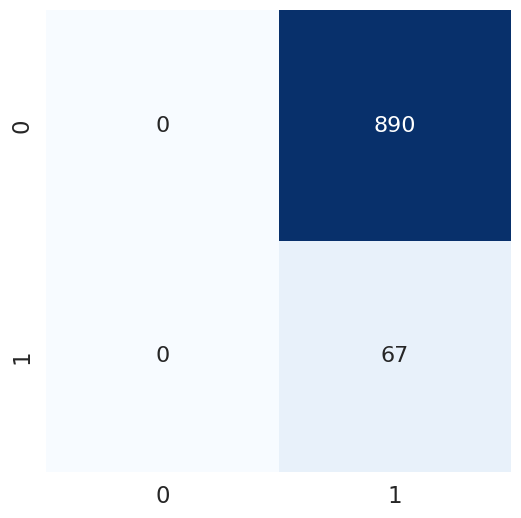

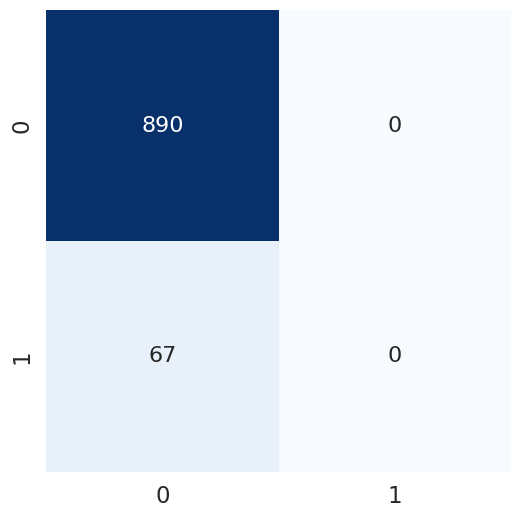

In [ ]:
# 导入和训练模型
lr = LogisticRegression(solver='newton-cg', class_weight='balanced')
# 可选择的class_weight 有 balnaced, balanced_subsample, 
## calculate weight Calculate weights using sklearn

rf = RandomForestClassifier(class_weight='balanced_subsample')

# 对训练数据集进行标准化
ss = StandardScaler()
#X_train_new = X_train[['DBDIET34', 'REVASC', 'ANGINA', 'ht_trial', 'LCALDIET', 'HEMOCCDT', 'MSMINWK','SCORE_baseline_sleep_p0.05_0.05']]
X_train_new = ss.fit_transform(X_train)

# 拟合模型
lr.fit(X_train_new, y_train)
rf.fit(X_train_new, y_train)

# 测试数据预测
pred_test = lr.predict(X_test)
pred_test_rf = rf.predict(X_test)

#计算并打印f1分数
f1_test = f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)

f1_test_rf = f1_score(y_test, pred_test_rf)
print('The f1 score for the testing data:', f1_test_rf)

# 绘制混淆矩阵
print('Classfication report: \n', classification_report(y_test, pred_test))
conf_matrix(y_test, pred_test)

print('Classfication report: \n', classification_report(y_test, pred_test_rf))
conf_matrix(y_test, pred_test_rf)

#### 3) 采用人工设置类权重 调整数据不平衡

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression(solver='newton-cg')

#设置类权重的范围
weights = np.linspace(0.0,0.99,200)

#为网格搜索创建字典网格
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

##用5倍网格搜索法拟合训练数据
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

In [ ]:
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})

In [ ]:
weigh_data['score'].max()

0.2043408126398656

In [ ]:
#绘制不同权重值的分数
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(x=weigh_data['weight'], y=weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

#### 4) 查看类权重后的roc-auc

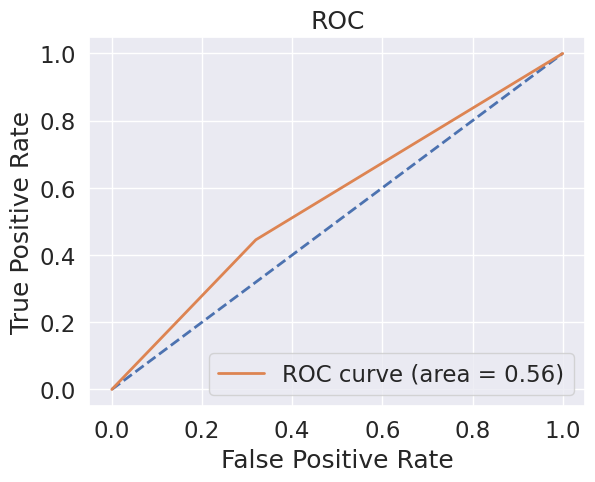

In [ ]:
# ROC Curve with logistic regression
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
pred_test= lr.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
auc = metrics.auc(fpr, tpr)
# plot ROC vurve
plt.figure()
lw = 2
plt.plot([0,1],[0,1], lw = lw, linestyle = '--')
plt.plot(fpr, tpr, lw = lw, label = 'ROC curve (area = %0.2f)' % auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc ="lower right")
plt.show()

## 3.3 spot-check algorithms

In [ ]:
# Spot-Check Algorithms
# LR, LDA, NB 三种模型的RECALL还可以，可以考虑重点关注该三种模型，采用FOR循环调参
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression(solver='newton-cg', class_weight='balanced')))
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('SVM'  , SVC(probability=True)))
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))

    
    return basedModels

In [ ]:
def BasedLine2(X_train, y_train, models):
  # Test options and evaluation metric
  num_folds = 10
  # score 的类型可以选择"accuracy"，"roc_auc", "f1", "precesion", "recall"
  scoring = "roc_auc"
  results = []
  names = []
  # StratifiedKFold 保证训练集中每一类的比例是相同的,其中参数含义：n_splits为折叠次数,shuffle: 是否在每次分割之前打乱顺序
  # cross_val_score 为交叉验证函数，其中参数含义，cv为每次选择验证折数 
  for name, model in models:
    kfold = StratifiedKFold(n_splits=num_folds, random_state=SEED,shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
  return names, results

In [ ]:
class PlotBoxR(object):
    
    
    def __Trace(self,nameOfFeature,value): 
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))


        py.iplot(data)

In [ ]:
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train, models)
# 箱式图 为 d最小值、第一四分位数、中位数、第三四分位数和最大值
PlotBoxR().PlotResult(names, results)

LR: 0.620358 (0.061537)
LDA: 0.645757 (0.054254)
KNN: 0.513338 (0.036004)
CART: 0.553610 (0.034780)
NB: 0.607541 (0.072656)
SVM: 0.514493 (0.050996)
AB: 0.618648 (0.067009)
GBM: 0.636646 (0.057455)
RF: 0.632376 (0.049596)
ET: 0.637517 (0.087454)


## 3.4 define dataframe genetating calculator

In [ ]:
def ScoreDataFrame(names, results):
  def floatingDecimals(f_val, dec=3):
    prc = "{:." + str(dec)+"f}"
    return float(prc.format(f_val))
  scores = []
  for r in results:
    scores.append(floatingDecimals(r.mean(),4))
  scoreDataFrame = pd.DataFrame({'Model':names, 'Score':scores})
  return scoreDataFrame

### 3.4.1 基线未做任何校正 各个模型的 accuracy

In [ ]:
## 基线未做任何调整的各个模型的 accuracy
basedLineScore = ScoreDataFrame(names, results)
basedLineScore
# results 为包含cv验证后的 accuracy（取均值)

,Model,Score
0,LR,0.4783
1,LDA,0.1217
2,KNN,0.0000
3,CART,0.1208
4,NB,0.3250
5,SVM,0.0000
6,AB,0.0454
7,GBM,0.0446
8,RF,0.0000
9,ET,0.0063


# 4 Feature Engineering

## 4.1 Data Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# .append() 将任何对象添加到给定列表
def GetScaledModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()

    pipelines = []
    pipelines.append((nameOfScaler+'_LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression(solver='newton-cg', class_weight = "balanced"))])))
    pipelines.append((nameOfScaler+'_LDA' , Pipeline([('Scaler', scaler),('LDA' , LinearDiscriminantAnalysis())])))
    pipelines.append((nameOfScaler+'_KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfScaler+'_CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfScaler+'_NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    pipelines.append((nameOfScaler+'_SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC())])))
    pipelines.append((nameOfScaler+'_AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostClassifier())])  ))
    pipelines.append((nameOfScaler+'_GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingClassifier())])  ))
    pipelines.append((nameOfScaler+'_RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])  ))
    pipelines.append((nameOfScaler+'_ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesClassifier())])  ))


    return pipelines 

### 有时scaling 也可提高 tree based model 的预测准确性

## 4.1.2 standard 标准化 Scaling method(第一次校正模型后的accuracy)

---



In [ ]:
## 选择standard标准化的方法，对x进行标准化
models = GetScaledModel('standard')
names,results = BasedLine2(X_train, y_train, models)
PlotBoxR().PlotResult(names, results)


standard_LR: 0.510833 (0.115593)
standard_LDA: 0.121667 (0.083204)
standard_KNN: 0.057500 (0.066217)
standard_CART: 0.063333 (0.049540)
standard_NB: 0.325000 (0.095215)
standard_SVM: 0.000000 (0.000000)
standard_AB: 0.045417 (0.065840)
standard_GBM: 0.037917 (0.041727)
standard_RF: 0.000000 (0.000000)
standard_ET: 0.006667 (0.020000)


### 采用standard校正后 模型 的 accuracy

In [ ]:
scaledScoreStandard = ScoreDataFrame(names, results)
## 经standard标准化之后的 各个模型的结果
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard], axis=1)
compareModels

,Model,Score,Model,Score
0,LR,0.5995,standard_LR,0.7700
1,LDA,0.6287,standard_LDA,0.7692
2,KNN,0.7177,standard_KNN,0.7266
3,CART,0.7518,standard_CART,0.6465
4,NB,0.6452,standard_NB,0.7092
5,SVM,0.5153,standard_SVM,0.7687
6,AB,0.8042,standard_AB,0.7555
7,GBM,0.8307,standard_GBM,0.7589
8,RF,0.8520,standard_RF,0.7638
9,ET,0.8892,standard_ET,0.7653


## 4.1.3 MinMax标准化方法(第一次模型校正后的accuracy)

In [ ]:
models = GetScaledModel('minmax')
names,results = BasedLine2(X_train_smo, y_train_smo, models)
PlotBoxR().PlotResult(names, results)


minmax_LR: 0.631270 (0.018884)
minmax_LDA: 0.628715 (0.016893)
minmax_KNN: 0.759505 (0.021654)
minmax_CART: 0.750559 (0.015073)
minmax_NB: 0.649158 (0.023338)
minmax_SVM: 0.753276 (0.015159)
minmax_AB: 0.805012 (0.015064)
minmax_GBM: 0.829447 (0.012118)
minmax_RF: 0.849889 (0.016982)
minmax_ET: 0.889493 (0.008164)


### 采用minmax 矫正后 模型的accuracy

In [ ]:
scaledScoreMinMax = ScoreDataFrame(names, results)
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard,
                           scaledScoreMinMax], axis = 1)
compareModels

,Model,Score,Model,Score,Model,Score
0,LR,0.5995,standard_LR,0.7700,minmax_LR,0.7675
1,LDA,0.6287,standard_LDA,0.7692,minmax_LDA,0.7692
2,KNN,0.7177,standard_KNN,0.7266,minmax_KNN,0.7357
3,CART,0.7518,standard_CART,0.6465,minmax_CART,0.6605
4,NB,0.6452,standard_NB,0.7092,minmax_NB,0.7092
5,SVM,0.5153,standard_SVM,0.7687,minmax_SVM,0.7663
6,AB,0.8042,standard_AB,0.7555,minmax_AB,0.7555
7,GBM,0.8307,standard_GBM,0.7589,minmax_GBM,0.7589
8,RF,0.8520,standard_RF,0.7638,minmax_RF,0.7651
9,ET,0.8892,standard_ET,0.7653,minmax_ET,0.7663


## 4.2 Remove Outliers

### Let's remove outliers and see how it effects on the prediction

In [ ]:
df_t = df_update.copy()
df_t_name = df_t.columns

In [ ]:
def TurkyOutliers(df_out,nameOfFeature,drop=False):
    valueOfFeature = df_out[nameOfFeature]
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(valueOfFeature, 25.)

    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(valueOfFeature, 75.)

    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3-Q1)*1.5
    # print "Outlier step:", step
    outliers = valueOfFeature[~((valueOfFeature >= Q1 - step) & (valueOfFeature <= Q3 + step))].index.tolist()
    feature_outliers = valueOfFeature[~((valueOfFeature >= Q1 - step) & (valueOfFeature <= Q3 + step))].values
    # df[~((df[nameOfFeature] >= Q1 - step) & (df[nameOfFeature] <= Q3 + step))]
   
    # Remove the outliers, if any were specified
    print ("Number of outliers (inc duplicates): {} and outliers: {}".format(len(outliers), feature_outliers))
    if drop:
        good_data = df_out.drop(df_out.index[outliers]).reset_index(drop = True)
        print ("New dataset with removed outliers has {} samples with {} features each.".format(*good_data.shape))
        return good_data
    else: 
        print ("Nothing happens, df.shape = ",df_out.shape)
        return df_out


In [ ]:
df_t.head(10)

,age,sbp,dbp,bmi,glu,chol,ldl,hdl,tg,insu,tot_cal,baseline_fat,baseline_pro,baseline_cho,baseline_sfa,baseline_mufa,baseline_pufa,baseline_alc,baseline_palm,baseline_n3,hei,baseline_sleepdis,baseline_ces_d,delta_sleep,coffee,time_walk_10min,cvd_his,hypertension_his,cancer_his,SCORE_baseline_sleep_p0.05_0.05,SCORE_inso_all_group,cvd_binary
0,59,115.0,80.0,35.62579,265.000000,283.00000,185.000000,68.000000,151.000000,113.000000,2909.92283,81.95551,117.69064,443.34403,31.21059,26.43309,17.67438,0.00634,15.89256,2.01256,77.25781,5.0,0.07820,0.441317,1.0,5.0,0.0,0.0,0.0,567.877,0.000188,1
1,51,125.0,84.0,41.22847,104.000000,215.00000,149.000000,36.000000,150.000000,70.000000,1524.63584,66.72611,60.70822,155.72613,13.92200,24.03499,23.54255,10.01349,8.64331,2.54322,63.98034,7.0,0.00144,-4.000000,1.0,0.0,0.0,0.0,0.0,557.363,0.000207,0
2,70,176.0,92.0,22.30924,84.000000,288.00000,203.000000,73.000000,62.000000,52.867359,1228.53449,40.19991,58.67646,160.10975,13.59158,14.54817,8.02075,0.00493,7.44353,0.82732,67.62396,5.0,0.00552,-1.000000,1.0,4.0,0.0,1.0,0.0,545.961,0.000162,0
3,69,112.0,61.0,32.26933,102.928474,234.47707,152.144631,52.554994,150.308914,52.867359,10.40186,0.62071,0.39478,0.66325,0.20647,0.18950,0.18983,0.00000,0.10192,0.01940,33.69145,11.0,0.00173,0.441317,1.0,4.0,0.0,0.0,1.0,544.527,0.000187,0
4,67,123.0,75.0,32.25674,93.000000,245.00000,157.000000,49.000000,192.000000,6.600000,548.58139,12.48523,11.24794,99.88404,4.25492,4.38228,2.81920,0.00046,2.12112,0.24068,50.62150,4.0,0.00173,1.000000,0.0,0.0,0.0,0.0,0.0,543.672,0.000239,0
5,54,104.0,69.0,26.87263,105.000000,219.00000,152.500000,50.500000,77.500000,34.200000,2456.97239,109.57551,105.39777,268.58096,40.51814,37.89930,22.66372,0.04528,21.16896,2.34198,56.51048,0.0,0.00144,8.000000,1.0,1.0,0.0,0.0,0.0,559.216,0.000280,0
6,74,194.0,86.0,28.37994,102.928474,234.47707,152.144631,52.554994,150.308914,52.867359,2267.00957,78.13344,111.14352,289.08074,24.27519,30.16302,17.82685,3.27085,13.37497,1.33236,81.89114,3.0,0.02123,0.441317,1.0,4.0,0.0,1.0,0.0,552.656,0.000178,0
7,70,127.0,71.0,38.01891,102.928474,234.47707,152.144631,52.554994,150.308914,52.867359,1069.65164,24.46105,55.08254,147.65314,11.11475,8.12573,3.52683,8.74159,5.47146,0.73413,75.95065,16.0,0.23272,0.441317,0.0,3.0,0.0,1.0,0.0,540.563,0.000149,0
8,74,128.0,71.0,20.85543,105.500000,291.00000,210.000000,70.000000,58.000000,15.900000,2112.96228,86.07637,75.09277,255.77008,31.81253,32.75094,15.77018,6.50838,16.29174,1.70033,62.18331,7.0,0.00173,1.000000,0.0,3.0,0.0,0.0,0.0,558.601,0.000227,0
9,72,107.0,66.0,27.10177,102.928474,234.47707,152.144631,52.554994,150.308914,52.867359,1188.08682,35.13830,67.38928,151.16586,8.71863,13.77161,9.36556,2.17688,5.27329,1.57331,77.09362,9.0,0.58322,0.441317,1.0,4.0,0.0,0.0,1.0,551.218,0.000227,0


In [ ]:
df_t['cvd_binary'].value_counts()

0    12729
1     3859
Name: cvd_binary, dtype: int64

### Feature 0

In [ ]:
feature_number = 0
OutLiersBox(df_t,df_t_name[feature_number])

In [ ]:
df_clean = TurkyOutliers(df_t, df_t_name[feature_number], True)
OutLiersBox(df_clean, df_name[feature_number])

### Feature 1

In [ ]:
feature_number = 1
OutLiersBox(df_t,df_t_name[feature_number])

In [ ]:
df_clean = TurkyOutliers(df_clean,df_t_name[feature_number],True)
OutLiersBox(df_clean,df_t_name[feature_number])

### Feature 2

In [ ]:
feature_number = 2
OutLiersBox(df_t,df_t_name[feature_number])

In [ ]:
df_clean = TurkyOutliers(df_clean,df_name[feature_number],True)
OutLiersBox(df_clean,df_name[feature_number])

### Feature 3

In [ ]:
feature_number = 3
OutLiersBox(df_t,df_t_name[feature_number])

In [ ]:
df_clean = TurkyOutliers(df_clean,df_name[feature_number],True)
OutLiersBox(df_clean,df_name[feature_number])

### Feature 4

In [ ]:
feature_number = 4
OutLiersBox(df,df_name[feature_number])

In [ ]:
df_clean = TurkyOutliers(df_clean,df_name[4],True)
OutLiersBox(df_clean,df_name[4])

### Feature 5

In [ ]:
feature_number = 5
OutLiersBox(df,df_name[feature_number])

In [ ]:
df_clean = TurkyOutliers(df_clean,df_name[feature_number],True)
OutLiersBox(df_clean,df_name[feature_number])

### Feature 6

In [ ]:
feature_number = 6
OutLiersBox(df,df_name[feature_number])

In [ ]:
df_clean = TurkyOutliers(df_clean,df_name[feature_number],True)
OutLiersBox(df_clean,df_name[feature_number])

### Feature 7

In [ ]:
feature_number = 7
OutLiersBox(df,df_name[feature_number])

In [ ]:
df_clean = TurkyOutliers(df_clean,df_name[feature_number],True)
OutLiersBox(df_clean,df_name[feature_number])

### Feature 8

In [ ]:
feature_number = 8
OutLiersBox(df,df_name[feature_number])

In [ ]:
df_clean = TurkyOutliers(df_clean,df_name[feature_number],True)
OutLiersBox(df_clean,df_name[feature_number])

### Feature 9

In [ ]:
feature_number = 9
OutLiersBox(df,df_name[feature_number])

In [ ]:
df_clean = TurkyOutliers(df_clean,df_name[feature_number],True)
OutLiersBox(df_clean,df_name[feature_number])

### Cleaning Report

In [ ]:
print('df shape: {}, new df shape: {}, we lost {} rows, {}% of our data'.format(df_t.shape[0],df_clean.shape[0],
                                                              df_t.shape[0]-df_clean.shape[0],
                                                        (df_t.shape[0]-df_clean.shape[0])/df_t.shape[0]*100))

df shape: 5832, new df shape: 5752, we lost 80 rows, 1.3717421124828533% of our data


In [ ]:
df_clean['cvd_binary'].value_counts()

0    12729
1     3859
Name: cvd_binary, dtype: int64

### double-check and compare the outliers between before and after removing the outliers

```
# This is formatted as code
```



In [ ]:
tt = OutLierDetection(df,'age','PC1',.1)

In [ ]:
tt_t = OutLierDetection(df_clean,'age','PC1',.1)

### Comparing the accuracy of models after cleaning

In [ ]:
df_clean.shape

(16588, 32)

In [ ]:
df_clean_name = df_clean.columns
X_c =  df_clean[df_clean_name[0:31]]
Y_c = df_clean[df_clean_name[31]]
X_train_c, X_test_c, y_train_c, y_test_c =train_test_split(X_c,Y_c,
                                                   test_size=0.3,
                                                   random_state=0,
                                                   stratify=df_clean['cvd_binary'])

In [ ]:
X_c.head(10)

,age,sbp,dbp,bmi,glu,chol,ldl,hdl,tg,insu,tot_cal,baseline_fat,baseline_pro,baseline_cho,baseline_sfa,baseline_mufa,baseline_pufa,baseline_alc,baseline_palm,baseline_n3,hei,baseline_sleepdis,baseline_ces_d,delta_sleep,coffee,time_walk_10min,cvd_his,hypertension_his,cancer_his,SCORE_baseline_sleep_p0.05_0.05,SCORE_inso_all_group
0,59,115.0,80.0,35.62579,265.000000,283.00000,185.000000,68.000000,151.000000,113.000000,2909.92283,81.95551,117.69064,443.34403,31.21059,26.43309,17.67438,0.00634,15.89256,2.01256,77.25781,5.0,0.07820,0.441317,1.0,5.0,0.0,0.0,0.0,567.877,0.000188
1,51,125.0,84.0,41.22847,104.000000,215.00000,149.000000,36.000000,150.000000,70.000000,1524.63584,66.72611,60.70822,155.72613,13.92200,24.03499,23.54255,10.01349,8.64331,2.54322,63.98034,7.0,0.00144,-4.000000,1.0,0.0,0.0,0.0,0.0,557.363,0.000207
2,70,176.0,92.0,22.30924,84.000000,288.00000,203.000000,73.000000,62.000000,52.867359,1228.53449,40.19991,58.67646,160.10975,13.59158,14.54817,8.02075,0.00493,7.44353,0.82732,67.62396,5.0,0.00552,-1.000000,1.0,4.0,0.0,1.0,0.0,545.961,0.000162
3,69,112.0,61.0,32.26933,102.928474,234.47707,152.144631,52.554994,150.308914,52.867359,10.40186,0.62071,0.39478,0.66325,0.20647,0.18950,0.18983,0.00000,0.10192,0.01940,33.69145,11.0,0.00173,0.441317,1.0,4.0,0.0,0.0,1.0,544.527,0.000187
4,67,123.0,75.0,32.25674,93.000000,245.00000,157.000000,49.000000,192.000000,6.600000,548.58139,12.48523,11.24794,99.88404,4.25492,4.38228,2.81920,0.00046,2.12112,0.24068,50.62150,4.0,0.00173,1.000000,0.0,0.0,0.0,0.0,0.0,543.672,0.000239
5,54,104.0,69.0,26.87263,105.000000,219.00000,152.500000,50.500000,77.500000,34.200000,2456.97239,109.57551,105.39777,268.58096,40.51814,37.89930,22.66372,0.04528,21.16896,2.34198,56.51048,0.0,0.00144,8.000000,1.0,1.0,0.0,0.0,0.0,559.216,0.000280
6,74,194.0,86.0,28.37994,102.928474,234.47707,152.144631,52.554994,150.308914,52.867359,2267.00957,78.13344,111.14352,289.08074,24.27519,30.16302,17.82685,3.27085,13.37497,1.33236,81.89114,3.0,0.02123,0.441317,1.0,4.0,0.0,1.0,0.0,552.656,0.000178
7,70,127.0,71.0,38.01891,102.928474,234.47707,152.144631,52.554994,150.308914,52.867359,1069.65164,24.46105,55.08254,147.65314,11.11475,8.12573,3.52683,8.74159,5.47146,0.73413,75.95065,16.0,0.23272,0.441317,0.0,3.0,0.0,1.0,0.0,540.563,0.000149
8,74,128.0,71.0,20.85543,105.500000,291.00000,210.000000,70.000000,58.000000,15.900000,2112.96228,86.07637,75.09277,255.77008,31.81253,32.75094,15.77018,6.50838,16.29174,1.70033,62.18331,7.0,0.00173,1.000000,0.0,3.0,0.0,0.0,0.0,558.601,0.000227
9,72,107.0,66.0,27.10177,102.928474,234.47707,152.144631,52.554994,150.308914,52.867359,1188.08682,35.13830,67.38928,151.16586,8.71863,13.77161,9.36556,2.17688,5.27329,1.57331,77.09362,9.0,0.58322,0.441317,1.0,4.0,0.0,0.0,1.0,551.218,0.000227


In [ ]:
X_train_c.head(10)

,age,sbp,dbp,bmi,glu,chol,ldl,hdl,tg,insu,tot_cal,baseline_fat,baseline_pro,baseline_cho,baseline_sfa,baseline_mufa,baseline_pufa,baseline_alc,baseline_palm,baseline_n3,hei,baseline_sleepdis,baseline_ces_d,delta_sleep,coffee,time_walk_10min,cvd_his,hypertension_his,cancer_his,SCORE_baseline_sleep_p0.05_0.05,SCORE_inso_all_group
11558,59,145.0,95.0,35.67649,102.928474,234.47707,152.144631,52.554994,150.308914,52.867359,928.40027,33.73242,53.59285,107.00766,12.55346,13.14584,4.79169,0.00000,6.97991,0.69117,71.45522,5.000000,0.00064,10.000000,0.0,4.0,0.0,0.0,0.0,551.554,0.000160
9510,69,112.0,69.0,26.70931,102.928474,234.47707,152.144631,52.554994,150.308914,52.867359,1190.58256,52.65685,40.75282,126.71293,19.38782,19.20724,9.82189,10.75839,9.79559,1.02857,64.08574,4.000000,0.00144,0.441317,0.0,1.0,0.0,0.0,0.0,529.630,0.000279
10863,70,128.0,82.0,28.80506,102.928474,234.47707,152.144631,52.554994,150.308914,52.867359,629.31624,15.36384,22.76862,103.40618,5.22646,5.28975,3.30918,0.99852,2.92227,0.45222,71.72833,14.000000,0.00554,0.441317,1.0,0.0,0.0,1.0,0.0,564.690,0.000209
16017,67,150.0,73.0,24.73702,102.928474,234.47707,152.144631,52.554994,150.308914,52.867359,1111.44289,42.65157,48.10053,117.20124,12.71276,16.00947,10.46962,12.44291,7.34583,1.28073,68.73373,6.871839,0.00173,0.441317,1.0,2.0,0.0,1.0,0.0,557.985,0.000212
6030,69,149.0,90.0,28.40058,102.928474,234.47707,152.144631,52.554994,150.308914,52.867359,2417.72304,106.82950,140.14810,226.32195,44.16623,41.30562,15.12239,0.01033,21.94072,1.90284,44.48678,6.000000,0.00173,5.000000,1.0,2.0,0.0,1.0,0.0,548.897,0.000185
4818,67,151.0,86.0,39.26279,100.000000,215.00000,140.000000,50.000000,127.000000,44.150000,3635.00736,171.07664,122.48967,414.04958,68.42968,60.90082,30.36982,0.13045,34.48390,2.92699,47.86126,0.000000,0.00144,1.000000,1.0,3.0,0.0,1.0,0.0,563.260,0.000242
10763,73,150.0,80.0,30.52388,107.000000,275.00000,187.000000,50.000000,193.000000,52.867359,1312.56923,29.36778,48.99483,223.75008,9.78473,10.69721,6.28571,1.77171,5.33544,1.02254,80.47189,13.000000,0.00131,-8.000000,0.0,4.0,1.0,1.0,0.0,536.555,0.000227
15610,69,135.0,85.0,24.28098,102.928474,234.47707,152.144631,52.554994,150.308914,52.867359,1055.45781,35.94007,45.53716,130.14386,10.40993,14.08460,8.99763,7.27594,5.63828,1.22128,81.01744,3.000000,0.00144,0.441317,1.0,3.0,0.0,1.0,0.0,552.402,0.000202
13300,69,126.0,76.0,35.25322,122.000000,253.00000,184.000000,52.000000,87.000000,36.000000,2065.45323,84.03266,80.96607,258.46154,26.79860,31.48535,19.89159,0.02062,14.57634,1.94475,77.15379,15.000000,0.00111,-2.000000,0.0,0.0,0.0,0.0,0.0,563.781,0.000181
13048,68,131.0,74.0,27.30119,102.928474,234.47707,152.144631,52.554994,150.308914,52.867359,1392.95799,42.58577,71.41482,183.51171,15.64339,15.39415,7.41876,2.35313,8.64472,1.04409,72.75193,7.000000,0.00131,0.441317,1.0,2.0,0.0,0.0,0.0,530.469,0.000195


In [ ]:
y_train_c.head(10)

11558    0
9510     0
10863    1
16017    0
6030     0
4818     0
10763    0
15610    0
13300    1
13048    0
Name: cvd_binary, dtype: int64

In [ ]:
Y_c.head(10)

0    1
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: cvd_binary, dtype: int64

### 4.2.1 perform all models by using clean dataset deleting outliers

In [ ]:
models = GetScaledModel('minmax')
names,results = BasedLine2(X_train_c, y_train_c,models)
PlotBoxR().PlotResult(names,results)

scaledScoreMinMax_c = ScoreDataFrame(names,results)
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard,
                          scaledScoreMinMax,
                          scaledScoreMinMax_c], axis=1)
compareModels

## 4.3 Feature Selection

### 4.3.1 Corrolation
#### we have to drop the one that has more corrolation with other features

In [ ]:
def HeatMap(df, x=True):
  correlations = df.corr()
  ## creat color map ranging between two colors
  ## diverging_palette()为创建两种颜色过渡色板
  cmap = sns.diverging_palette(220, 10,as_cmap=True)
  fig, ax = plt.subplots(figsize=(10,10))
  ## heatmap中参数: vmin和vmax定义图卡颜色，用于锚定颜色图的值
  # cmap 颜色映射名称或对象; fmt 添加注释时要使用的字符串格式化代码
  fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, vmin=-1.0,
                    fmt='.2f',square=True,linewidths=.5, 
                    annot=x, cbar_kws={'shrink': .75})
  fig.set_xticklabels(fig.get_xticklabels(), rotation = 60, fontsize = 10)
  fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 10)
  plt.tight_layout()
  plt.show()
HeatMap(df_update4[['DBDIET34', 'REVASC', 'ANGINA', 'ht_trial', 'LCALDIET', 'HEMOCCDT', 'MSMINWK','SCORE_baseline_sleep_p0.05_0.05']],x=True)

SyntaxError: ignored

### 4.3.2 Feature Importance

In [ ]:
## ExtraTreesClassifier 它将森林中收集的多个去相关决策树的结果聚集起来输出分类结果
clf = ExtraTreesClassifier(n_estimators=250,
                              random_state=SEED)

clf.fit(X_train_c, y_train_c)

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5


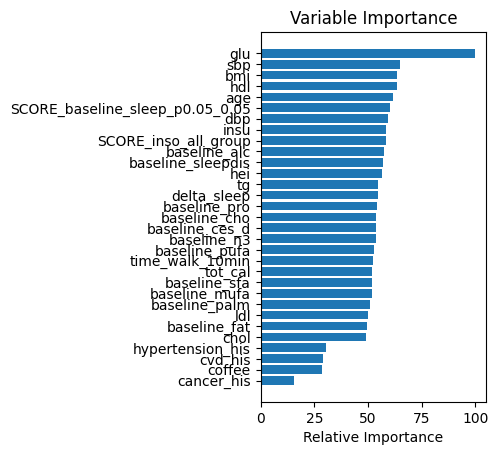

In [ ]:
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df_clean.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### 4.3.3 select important features

In [ ]:
df_feature_imp=df_clean[['sbp','SCORE_baseline_sleep_p0.05_0.05','delta_sleep','age','baseline_ces_d','dbp','hei','bmi','baseline_alc','baseline_sleepdis',
                         'baseline_cho','tot_cal','time_walk_10min','cvd_his','coffee','hypertension_his','mi']]

In [ ]:
df_feature_imp_name = df_feature_imp.columns

In [ ]:
X_im =  df_feature_imp[df_feature_imp_name[0:df_feature_imp.shape[1]-1]]
Y_im = df_feature_imp[df_feature_imp_name[df_feature_imp.shape[1]-1]]
X_train_im, X_test_im, y_train_im, y_test_im =train_test_split(X_im,Y_im,
                                                   test_size=0.3,
                                                   random_state=0,
                                                   stratify=df_feature_imp['mi'])

In [ ]:
X_train_im.head()

,sbp,SCORE_baseline_sleep_p0.05_0.05,delta_sleep,age,baseline_ces_d,dbp,hei,bmi,baseline_alc,baseline_sleepdis,baseline_cho,tot_cal,time_walk_10min,cvd_his,coffee,hypertension_his
93,122.0,559.337,0.634052,69,0.04899,74.0,44.13708,26.01134,16.45891,14.0,159.34609,1626.74898,1.0,1.000000,1.0,0.0
3309,134.0,528.650,-2.000000,62,0.00507,68.0,59.34715,24.68698,0.14743,3.0,178.49966,1402.10651,4.0,0.000000,1.0,0.0
791,135.0,552.314,0.634052,67,0.00144,81.0,66.27162,31.69879,0.78340,6.0,195.33402,1984.36866,3.0,0.000000,0.0,0.0
2838,159.0,565.936,-5.000000,67,0.00383,61.0,75.58626,29.22964,7.34947,6.0,195.69896,1572.49283,4.0,1.000000,1.0,1.0
1453,155.0,571.222,1.000000,61,0.42214,89.0,59.95999,40.66208,2.69923,8.0,395.22391,4303.14865,3.0,0.175374,1.0,1.0


In [ ]:
y_train_im.value_counts()

0    3752
1     274
Name: mi, dtype: int64

In [ ]:
models = GetScaledModel('minmax')
names,results = BasedLine2(X_train_im, y_train_im,models)
PlotBoxR().PlotResult(names,results)

scaledScoreMinMax_im = ScoreDataFrame(names,results)
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard,
                          scaledScoreMinMax,
                          scaledScoreMinMax_c,
                          scaledScoreMinMax_im], axis=1)
compareModels

#### 4.3.4 Calculate confusion matrix with random forest model

Confusion matrix: 
 [[1219  123]
 [ 348   60]]
Classfication report: 
               precision    recall  f1-score   support

           0       0.78      0.91      0.84      1342
           1       0.33      0.15      0.20       408

    accuracy                           0.73      1750
   macro avg       0.55      0.53      0.52      1750
weighted avg       0.67      0.73      0.69      1750



Text(46.25, 0.5, 'true')

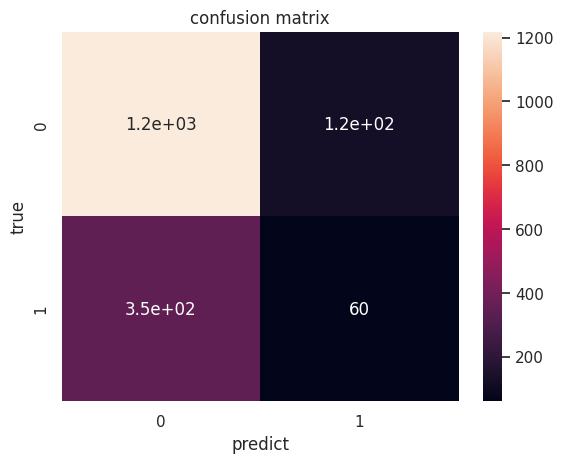

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
rf = RandomForestClassifier(random_state = 4)
rf.fit(X_train_smo, y_train_smo)
y_pred_smo = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_smo)
print('Confusion matrix: \n', cm )
print('Classfication report: \n', classification_report(y_test, y_pred_smo))
# 绘制 confusin matrix 的热力图
sns.set()
f, ax = plt.subplots()
sns.heatmap(cm, annot = True, ax = ax)
ax.set_title('confusion matrix')
ax.set_xlabel('predict')
ax.set_ylabel('true')

In [ ]:
y_pred_smo

array([0, 0, 0, ..., 0, 0, 0])

#### 4.3.5 Generating AUC & ROC plot

In [ ]:
# ROC Curve with logistic regression
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
y_pred = rf.predict(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
# plot ROC vurve
plt.figure()
lw = 2
plt.plot([0,1],[0,1], lw = lw, linestyle = '--')
plt.plot(fpr, tpr, lw = lw, label = 'ROC curve (area = %0.2f)' % auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc ="lower right")
plt.show()

#### 4.3.6 Scaled important features

In [ ]:
df_unscaled = df_clean[['sbp','SCORE_baseline_sleep_p0.05_0.05','delta_sleep','age','baseline_ces_d','dbp','hei','bmi','baseline_alc','baseline_sleepdis',
                         'baseline_cho','tot_cal','time_walk_10min','cvd_his','coffee','hypertension_his','mi']]
df_imp_scaled_name = df_unscaled.columns

In [ ]:
df_unscaled.shape

(5752, 17)

In [ ]:
df_imp_scaled = MinMaxScaler().fit_transform(df_unscaled)
X =  df_imp_scaled[:,0:16]
Y =  df_imp_scaled[:,16]
X_train_sc, X_test_sc, y_train_sc, y_test_sc =train_test_split(X,Y,
                                                   test_size=0.3,
                                                   random_state=0,
                                                   stratify=df_imp_scaled[:,16])

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform

In [ ]:
class RandomSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def RandomSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=1,
                                 n_iter=100,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.RandomSearch()
        pred = best_model.predict(X_test)
        return pred

In [ ]:
class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred

## 4.4 Calculate SHAP values

In [ ]:
## install shap
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 9.3 MB/s eta 0:00:00


In [ ]:
import xgboost
import shap
shap.initjs()

In [ ]:
# train xgb model
xgb_model = xgboost.train({'learning_rate':0.01}, xgboost.DMatrix(X, label = Y), 100)

### 4.4.1 explainer

In [ ]:
# Explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

### 4.4.2 local interper 

In [ ]:
# 单个prediction的解释
# 可视化第一个prediction 的解释
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
# 多个预测的解释
shap.force_plot(explainer.expected_value, shap_values, X)

### 4.4.3 Global Interper

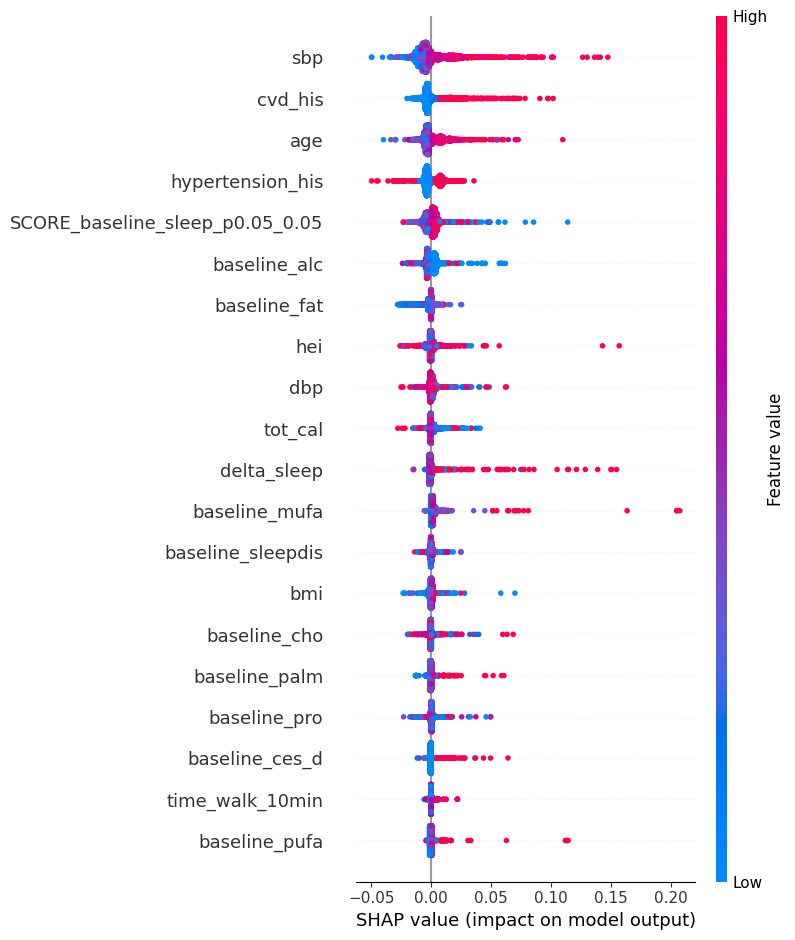

In [ ]:
# summary plot 为每个样本绘制其每个特征的shap值，可更好的解释整体模型，并允许发现异常值
shap.summary_plot(shap_values, X)

### 4.4.4 Feature Important

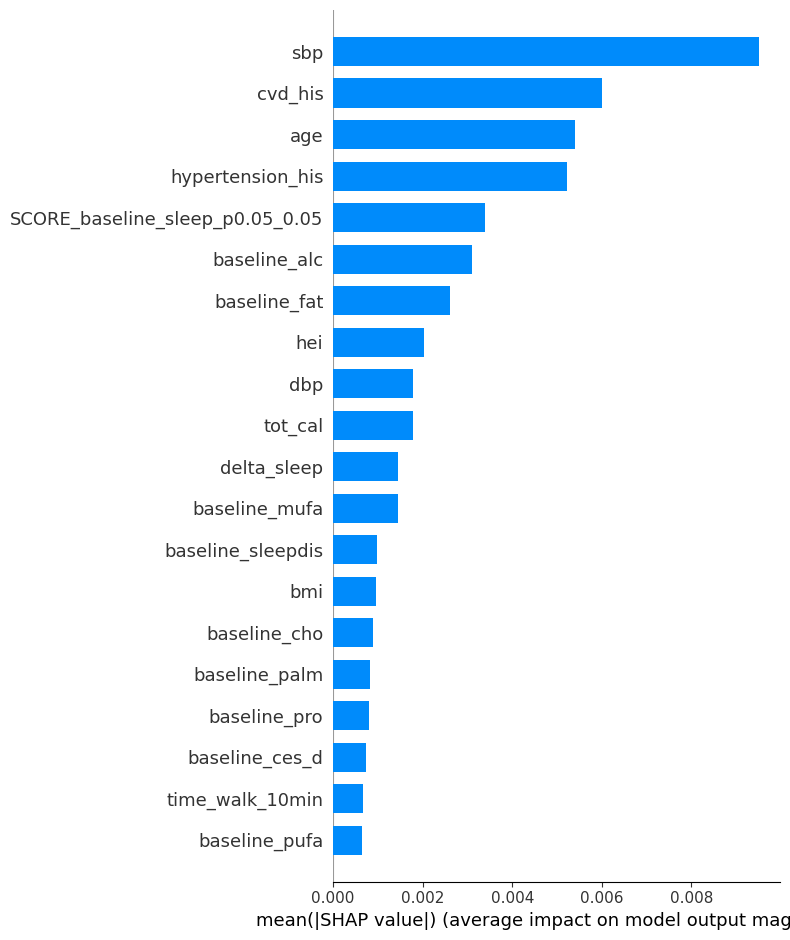

In [ ]:
shap.summary_plot(shap_values,X, plot_type="bar")

## 5 Hyperparameters estimate by using gridsearch method

### 5.1 Logistic Regression

In [ ]:
# model
model = LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

NameError: ignored

In [ ]:
LR_RandSearch = RandomSearch(X_train_sc,y_train_sc,model,hyperparameters)
# LR_best_model,LR_best_params = LR_RandSearch.RandomSearch()
Prediction_LR = LR_RandSearch.BestModelPridict(X_test_sc)

Best: 0.931943 using {'C': 3.730229437354635, 'penalty': 'l2'}


In [ ]:
def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" #first cast decimal as str
    #     print(prc) #str format output is {:.3f}
        return float(prc.format(f_val))

In [ ]:
print('prediction on test set is:' ,floatingDecimals((y_test_sc == Prediction_LR).mean(),7))

prediction on test set is: 0.9322132


### 5.2 knn

In [ ]:
# n_neighbors: Number of neighbors to use by default for k_neighbors queries
model_KNN = KNeighborsClassifier()

neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_grid = dict(n_neighbors=neighbors)

In [ ]:
KNN_GridSearch = GridSearch(X_train_sc,y_train_sc,model_KNN,param_grid)
Prediction_KNN = KNN_GridSearch.BestModelPridict(X_test_sc)
print('prediction on test set is:' ,floatingDecimals((y_test_sc == Prediction_KNN).mean(),7))

Best: 0.931944 using {'n_neighbors': 6}
prediction on test set is: 0.9322132


### 5.3 svc

In [ ]:
# C: The Penalty parameter C of the error term.
# Kernel: Kernel type could be linear, poly, rbf or sigmoid.
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = [ 'linear' , 'poly' , 'rbf' , 'sigmoid' ]
param_grid = dict(C=c_values, kernel=kernel_values)
model_SVC = SVC()

In [ ]:
SVC_GridSearch = GridSearch(X_train_sc,y_train_sc,model_SVC,param_grid)
Prediction_SVC = SVC_GridSearch.BestModelPridict(X_test_sc)
print('prediction on test set is:' ,floatingDecimals((y_test_sc == Prediction_SVC).mean(),7))

Best: 0.931943 using {'C': 0.1, 'kernel': 'linear'}
prediction on test set is: 0.9322132


### 5.4 Decision Tree

In [ ]:
# max_depth: Maximum depth of the tree (double).
# row_subsample: Proportion of observations to consider (double).
# max_features: Proportion of columns (features) to consider in each level (double).

from scipy.stats import randint
max_depth_value = [3, None]
max_features_value =  randint(1, 4)
min_samples_leaf_value = randint(1, 4)
criterion_value = ["gini", "entropy"]

In [ ]:
param_grid = dict(max_depth = max_depth_value,
                  max_features = max_features_value,
                  min_samples_leaf = min_samples_leaf_value,
                  criterion = criterion_value)

In [ ]:
model_CART = DecisionTreeClassifier()
CART_RandSearch = RandomSearch(X_train_sc,y_train_sc,model_CART,param_grid)
Prediction_CART = CART_RandSearch.BestModelPridict(X_test_sc)
print('prediction on test set is:' ,floatingDecimals((y_test_sc == Prediction_CART).mean(),7))

Best: 0.932191 using {'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 1}
prediction on test set is: 0.9310545


### 5.5 AdaBoostClassifier

In [ ]:
# learning_rate: Learning rate shrinks the contribution of each classifier by learning_rate.
# n_estimators: Number of trees to build.
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300]

param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)

In [ ]:
model_Ad = AdaBoostClassifier()
Ad_GridSearch = GridSearch(X_train_sc,y_train_sc,model_Ad,param_grid)
Prediction_Ad = Ad_GridSearch.BestModelPridict(X_test_sc)
print('prediction on test set is:' ,floatingDecimals((y_test_sc == Prediction_Ad).mean(),7))

Best: 0.931943 using {'learning_rate': 0.01, 'n_estimators': 50}
prediction on test set is: 0.9322132


### 5.6 GradientBoosting

In [ ]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300]

param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)

In [ ]:
model_GB = GradientBoostingClassifier()
GB_GridSearch = GridSearch(X_train_sc,y_train_sc,model_GB,param_grid)
Prediction_GB = GB_GridSearch.BestModelPridict(X_test_sc)
print('prediction on test set is:' ,floatingDecimals((y_test_sc == Prediction_GB).mean(),7))

Best: 0.931943 using {'learning_rate': 0.01, 'n_estimators': 50}
prediction on test set is: 0.9322132


## 6 Ensemble Methods

### 6.1 Voting Ensemble

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
param = {'C': 3.730229437354635, 'penalty': 'l2'}
model1 = LogisticRegression(**param)

param = {'n_neighbors': 6}
model2 = KNeighborsClassifier(**param)

param = {'C': 0.1, 'kernel': 'linear'}
model3 = SVC(**param)

param = {'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 1}
model4 = DecisionTreeClassifier(**param)

param = {'learning_rate': 0.01, 'n_estimators': 50}
model5 = AdaBoostClassifier(**param)

param = {'learning_rate': 0.01, 'n_estimators': 50}
model6 = GradientBoostingClassifier(**param)

model7 = GaussianNB()

model8 = RandomForestClassifier()

model9 = ExtraTreesClassifier()

In [ ]:
# create the sub models
estimators = [('LR',model1), ('KNN',model2), ('SVC',model3),
              ('DT',model4), ('ADa',model5), ('GB',model6),
              ('NB',model7), ('RF',model8),  ('ET',model9)]

In [ ]:
# create the sub models
estimators = [('LR',model1), ('KNN',model2), ('SVC',model3),
              ('DT',model4), ('ADa',model5), ('GB',model6),
              ('NB',model7), ('RF',model8),  ('ET',model9)]
              
# create the ensemble model
kfold = StratifiedKFold(n_splits=10, random_state=SEED, shuffle=True)
ensemble = VotingClassifier(estimators)
## cross_val_score 为交叉验证函数，其中参数含义，cv为每次选择验证折数 
results = cross_val_score(ensemble, X_train_sc, y_train_sc, cv=kfold, scoring = "accuracy")
print('Accuracy on train: ',results.mean())
ensemble_model = ensemble.fit(X_train_sc,y_train_sc)
pred = ensemble_model.predict(X_test_sc)
print('Accuracy on test:' , (y_test_sc == pred).mean())

Accuracy on train:  0.9319432613606905
Accuracy on test: 0.9322132097334879


### Beyond Voting

In [ ]:
def get_models():
    """Generate a library of base learners."""
    param = {'C': 3.730229437354635, 'penalty': 'l2'}
    model1 = LogisticRegression(**param)

    param = {'n_neighbors': 6}
    model2 = KNeighborsClassifier(**param)

    param = {'C': 0.1, 'kernel': 'linear', 'probability':True}
    model3 = SVC(**param)

    param = {'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 1}
    model4 = DecisionTreeClassifier(**param)

    param = {'learning_rate': 0.01, 'n_estimators': 50}
    model5 = AdaBoostClassifier(**param)

    param = {'learning_rate': 0.01, 'n_estimators': 50}
    model6 = GradientBoostingClassifier(**param)

    model7 = GaussianNB()

    model8 = RandomForestClassifier()

    model9 = ExtraTreesClassifier()

    models = {'LR':model1, 'KNN':model2, 'SVC':model3,
              'DT':model4, 'ADa':model5, 'GB':model6,
              'NB':model7, 'RF':model8,  'ET':model9
              }

    return models

## 6.2. Error Corrolation

In [ ]:
def train_predict(model_list,xtrain, xtest, ytrain, ytest):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P

In [ ]:
models = get_models()
P = train_predict(models,X_train_sc,X_test_sc,y_train_sc,y_test_sc)

Fitting models.
LR... done
KNN... done
SVC... done
DT... done
ADa... done
GB... done
NB... done
RF... done
ET... done
Done.



In [ ]:
!pip install mlens

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 KB 8.7 MB/s eta 0:00:00


[MLENS] backend: threading


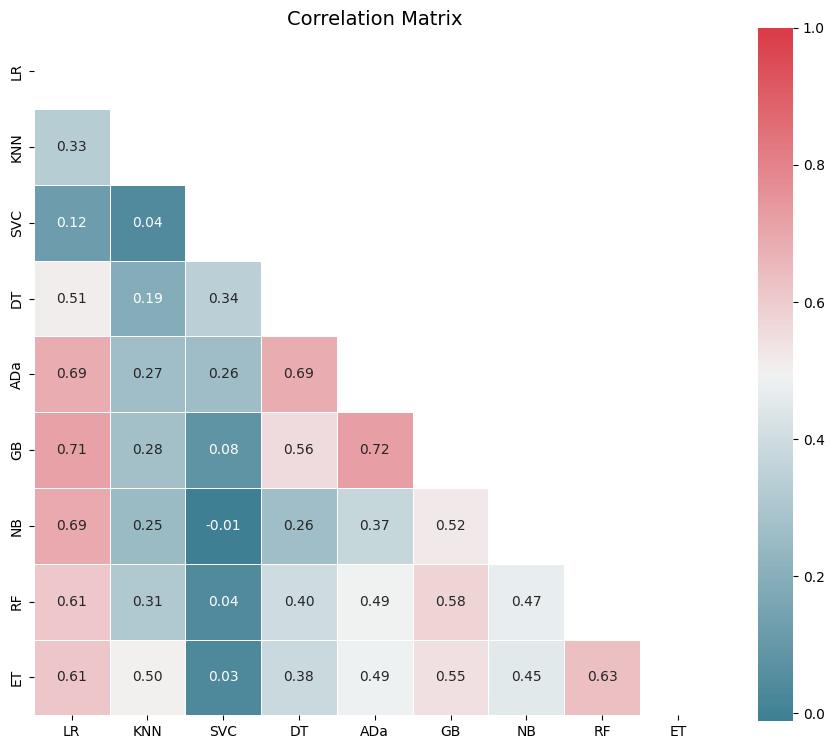

<Axes: title={'center': 'Correlation Matrix'}>

In [ ]:
from mlens.visualization import corrmat
corrmat(P.corr(), inflate=False)

In [ ]:
corrmat(P.apply(lambda predic: 1*(predic >= 0.5) - y_test_sc).corr(), inflate=False)

In [ ]:
base_learners = get_models()
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=6,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.001, 
    random_state=SEED
)

In [ ]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=SEED,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(X_train_sc, y_train_sc)

# Predict the test set
p_sl = sl.predict_proba(X_test_sc)

#print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(y_test_sc, p_sl[:, 1]))


Fitting 2 layers
Processing layer-1             

In [ ]:
pp = []
for p in p_sl[:, 1]:
    if p>0.5:
        pp.append(1.)
    else:
        pp.append(0.)

In [ ]:
print("\nSuper Learner Accuracy score: %.8f" % (y_test_sc== pp).mean())


Super Learner Accuracy score: 0.85937500
